In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import plotly.graph_objects as go
import re
from datetime import datetime as dt
from datetime import timedelta, timezone

import libpbeastpy

db = libpbeastpy.ServerProxy('http://pc-tbed-bst-prod:8080')

pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
# fsm_df = pd.read_parquet('/eos/home-i03/m/mdtoffline//mdt_dcs_offline/streamlit/mdt-dcs-saved-run-analysis/481616/csv/mdt_fsm_flags_df.parquet')

In [22]:
start_dt = '2024-07-17 15:30:00.000000+0200' # from atlas-datasummary.web.cern.ch
end_dt = '2024-07-18 17:21:00.000000+0200'

fmt = '%Y-%m-%d %H:%M:%S.%f%z'

since_dt = dt.strptime(start_dt, fmt)
till_dt = dt.strptime(end_dt, fmt)
print("Query Start Time:", since_dt)
print("Query Start Time:", since_dt.astimezone(tz=timezone.utc).replace(tzinfo=None))
print("Query End Time:", till_dt, '\n')

since_ts = int((pd.to_datetime(start_dt)).timestamp()*1e6)
till_ts = int((pd.to_datetime(end_dt)).timestamp()*1e6)

Query Start Time: 2024-07-17 15:30:00+02:00
Query Start Time: 2024-07-17 13:30:00
Query End Time: 2024-07-18 17:21:00+02:00 



In [23]:
def queryDataToDataFrame(queryData):   
    
    # Define a regular expression pattern to match the timestamp and value
    pattern = r"DataPoint\(ts=(\d+), value=('.*?'|[0-9.]+)\)"
    row =[]
    try:
        for key in queryData[0].data.keys():
            for x in queryData[0].data[key]:
                # Use re.match to find the values
                match = re.match(pattern, str(x))
                if match:
                    timestamp = match.group(1)
                    value = match.group(2)
                    #print(f"Timestamp: {timestamp}, Value: {value}")
                else:
                    print("The string does not match the expected format.")
                    return
                row.append((key,timestamp,value))
                
        # Define column names
        column_names = ['datapoint', 'ts', 'value']
    
        # Create the DataFrame using the list of tuples
        df = pd.DataFrame(row, columns = column_names)

    except IndexError:

        df = pd.DataFrame({'datapoint': np.array([], dtype=str), 'ts' : np.array([], dtype=int), 'value' : np.array([], dtype=int)})
        
    return df

In [24]:
def query_lib_data(since_ts, till_ts, query, source = 'DCS', type = 'number'):
    
    queryData = db.get_data('DCS', 
                            f'ATLAS_PVSS{source}', 
                            f'value-{type}', 
                            query, 
                            True, 
                            since_ts, 
                            till_ts, 
                            0, 
                            True)

    df = queryDataToDataFrame(queryData)
    df.sort_values(by=['ts'], inplace=True)
    df['dt'] = df['ts'].apply(lambda x : pd.Timestamp(int(x)*1000, tz='Europe/Zurich'))
    
    if type == 'number':
        
        df['value'] = df['value'].astype(float)
    
    return df

In [25]:
# mdt_fsm_status_df = query_lib_data(0, till_ts, '.*_JTAG.*fsm.currentState|.*_ML1.*fsm.currentState|.*_ML2.*fsm.currentState|.*_LV.*fsm.currentState', 'MDT', 'string')
# mdt_fsm_status_df.sort_values('ts')

In [ ]:
mdt_fsm_status_df = query_lib_data(since_ts, till_ts, '.*_JTAG.*fsm.currentState|.*_ML1.*fsm.currentState|.*_ML2.*fsm.currentState|.*_LV.*fsm.currentState', 'MDT', 'string')
    
mdt_fsm_flags_df  = mdt_fsm_status_df[(mdt_fsm_status_df['value'] != "'OFF'") & 
                                     (mdt_fsm_status_df['value'] != "'ON'") & 
                                     (mdt_fsm_status_df['value'] != "'STANDBY'") & 
                                     (mdt_fsm_status_df['value'] != "'INITIALIZED'") & 
                                     (mdt_fsm_status_df['value'] != "'RAMP_UP'") & 
                                     (mdt_fsm_status_df['value'] != "'RAMPING'") & 
                                     (mdt_fsm_status_df['value'] != "'RAMP_DOWN'") & 
                                     (mdt_fsm_status_df['value'] != "'REQUEST'") & 
                                     (mdt_fsm_status_df['value'] != "'PRELOAD'") & 
                                     (mdt_fsm_status_df['value'] != "'VERIFY'") & 
                                     (mdt_fsm_status_df['value'] != "'RESET'") & 
                                     (mdt_fsm_status_df['value'] != "'STRINGLOAD'") & 
                                     (mdt_fsm_status_df['value'] != "'READY'")]

mdt_fsm_flags_df['ts'] = mdt_fsm_flags_df['ts'].astype(int)

# mdt_fsm_flags_df = mdt_fsm_flags_df[(mdt_fsm_flags_df['dt'] > sb_start_dt) & (mdt_fsm_flags_df['dt'] < sb_end_dt)]

fsm_df = mdt_fsm_flags_df[mdt_fsm_flags_df['datapoint'].str.contains('JTAG')]
fsm_df['chamber_name'] = fsm_df['datapoint'].apply(lambda x : ''.join(list(x.split('|')[1][:7])))

In [28]:
# %pip install fastparquet

# import sys
# sys.path.append('/eos/home-i03/m/mdtoffline/.local/lib/python3.9/site-packages')

In [29]:
# fsm_df.to_parquet('test_fsm.parquet')

In [ ]:
# fsm_df = pd.read_parquet('test_fsm.parquet')

In [ ]:
# chamber_data_eoc = {}
# for ring_index in range(6):
#     for segment_index in range(16):
#         if segment_index < 10:
#             chamber_name = f'EO{ring_index}C0{segment_index}'
#         else:
#             chamber_name = f'EO{ring_index}C{segment_index}'
#         chamber_data_eoc[chamber_name] = ring_index * 16 + segment_index

# chamber_data_eoa = {}
# for ring_index in range(6):
#     for segment_index in range(16):
#         if segment_index < 10:
#             chamber_name = f'EO{ring_index}A0{segment_index}'
#         else:
#             chamber_name = f'EO{ring_index}A{segment_index}'
#         chamber_data_eoa[chamber_name] = ring_index * 16 + segment_index


# # Create a figure and axes for two subplots
# fig, axes = plt.subplots(1, 2, figsize=(12, 22), dpi = 300) # 1 row, 2 columns, size to 12x6

# # Remove axis from subplots
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlim(-7.5, 7.5) # expanded range to -12 to 12
#     ax.set_ylim(-9, 9)
#     ax.axis('off')

# # Draw EOC pattern on the first subplot
# draw_EOC_pattern(axes[0], chamber_data_eoc, fsm_df)
# axes[0].text(0.0, 8.4, 'EOC', fontsize=12, ha='center')
# axes[0].text(-8.0, 0.0, '1', fontsize=12)
# axes[0].text(8.0, 0.0, '9', fontsize=12)
# axes[0].text(0.0, 7.4, '5', fontsize=12, ha='center')
# axes[0].text(0.0, -8.4, '13', fontsize=12, ha='center')


# # Draw EOA pattern on the second subplot with offset
# draw_EOA_pattern(axes[1], chamber_data_eoa, fsm_df, x_offset=0)
# axes[1].text(0.0, 8.4, 'EOA', fontsize=12, ha='center')
# axes[1].text(-8.0, 0.0, '1', fontsize=12)
# axes[1].text(8.0, 0.0, '9', fontsize=12)
# axes[1].text(0.0, 7.4, '5', fontsize=12, ha='center')
# axes[1].text(0.0, -8.4, '13', fontsize=12, ha='center')
    
# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

In [62]:
def plot_ei(fsm_df, side):

    fig = go.Figure()

    center = np.array([0, 0])
    polygon_center_xs = []
    polygon_center_ys = []
    chamber_names = []
    radius_inner = 1.0
    radius_outer = 8.0
    num_sections = 16
    num_eta = 8
    angular_offset = np.pi / num_sections + np.pi

    def get_vertex_coords(radius, angle, offset = 0):
        x = center[0] + (radius + offset) * np.cos(angle)
        y = center[1] + (radius + offset) * np.sin(angle)
        return [x, y]

    def get_polygon_vertices(ring_index, segment_index, offset = 0):
        start_angle = - 2 * np.pi * (segment_index - 1) / num_sections - angular_offset
        end_angle = - 2 * np.pi * (segment_index) / num_sections - angular_offset
        
        inner_radius = radius_inner + ring_index
        outer_radius = radius_inner + ring_index + 1

        v1 = get_vertex_coords(inner_radius, start_angle, offset)
        v2 = get_vertex_coords(inner_radius, end_angle, offset)
        v3 = get_vertex_coords(outer_radius, end_angle, offset)
        v4 = get_vertex_coords(outer_radius, start_angle, offset)
        
        return [v1, v2, v3, v4]

    # Draw the polygons
    for ring_index in range(num_eta):
        
        for segment_index in range(num_sections):
            
            # Get the chamber name
            if ring_index == 3:

                if segment_index % 2 == 0:

                    chamber_name = f'EIL{ring_index+1}{side}0{segment_index+1}'
                    chamber_names.append(chamber_name)

                    polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
                    # Calculate the polygon center
                    polygon_center_x = np.mean([v[0] for v in polygon_vertices])
                    polygon_center_y = np.mean([v[1] for v in polygon_vertices])

                    polygon_center_xs.append(polygon_center_x)
                    polygon_center_ys.append(polygon_center_y)

                    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
                    list_of_errors = tmp_df['value'].values
                
                    # Choose the color based on whether the chamber is in fsm_df
                    if len(tmp_df) > 0:
                        fillcolor = 'crimson'
                        text = f'{chamber_name}: {list_of_errors}'
                    else:
                        fillcolor = 'lime'
                        text = f'{chamber_name}: READY'
        
                    # Create the polygon
                    x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
                    y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]
        
                    fig.add_trace(go.Scatter(
                        x=x_vals, y=y_vals,
                        mode = 'lines',
                        fill='toself',
                        fillcolor=fillcolor,
                        line=dict(color='black'),
                    ))

                    fig.add_trace(go.Scatter(
                        x=[polygon_center_x], y=[polygon_center_y],
                        marker_color = fillcolor,
                        marker_size = 1,
                        name=chamber_name,
                        hoverinfo='text',
                        text=text,
                    ))
        
            elif ring_index > 5:

                if segment_index == 4:

                    if ring_index == 7:
                
                        chamber_name = f'EEL{ring_index+1-6}{side}0{segment_index+1}'
                        chamber_names.append(chamber_name)
        
                        polygon_vertices = get_polygon_vertices(ring_index, segment_index, offset = -.5)
                
                        # Calculate the polygon center
                        polygon_center_x = np.mean([v[0] for v in polygon_vertices])
                        polygon_center_y = np.mean([v[1] for v in polygon_vertices])

                        polygon_center_xs.append(polygon_center_x)
                        polygon_center_ys.append(polygon_center_y)
            
                        # Choose the color based on whether the chamber is in fsm_df
                        tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
                        list_of_errors = tmp_df['value'].values
                    
                        # Choose the color based on whether the chamber is in fsm_df
                        if len(tmp_df) > 0:
                            fillcolor = 'crimson'
                            text = f'{chamber_name}: {list_of_errors}'
                        else:
                            fillcolor = 'lime'
                            text = f'{chamber_name}: READY'
            
                        # Create the polygon
                        x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
                        y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]
            
            
                        fig.add_trace(go.Scatter(
                            x=x_vals, y=y_vals,
                            mode = 'lines',
                            fill='toself',
                            fillcolor=fillcolor,
                            line=dict(color='black')
                        ))
                        fig.add_trace(go.Scatter(
                            x=[polygon_center_x], y=[polygon_center_y],
                            marker_color = fillcolor,
                            marker_size = 1,
                            name=chamber_name,
                            hoverinfo='text',
                            text=text,
                        ))
                
                else:

                    if segment_index % 2 == 0:

                        chamber_name = f'EEL{ring_index+1-6}{side}0{segment_index+1}'

                    else:

                        chamber_name = f'EES{ring_index+1-6}{side}0{segment_index+1}'
                        
                    chamber_names.append(chamber_name)
                    
                    polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
                    # Calculate the polygon center
                    polygon_center_x = np.mean([v[0] for v in polygon_vertices])
                    polygon_center_y = np.mean([v[1] for v in polygon_vertices])

                    polygon_center_xs.append(polygon_center_x)
                    polygon_center_ys.append(polygon_center_y)
        
                    # Choose the color based on whether the chamber is in fsm_df
                    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
                    list_of_errors = tmp_df['value'].values
                
                    # Choose the color based on whether the chamber is in fsm_df
                    if len(tmp_df) > 0:
                        fillcolor = 'crimson'
                        text = f'{chamber_name}: {list_of_errors}'
                    else:
                        fillcolor = 'lime'
                        text = f'{chamber_name}: READY'
        
                    # Create the polygon
                    x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
                    y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]
        
        
                    fig.add_trace(go.Scatter(
                        x=x_vals, y=y_vals,
                        mode = 'lines',
                        fill='toself',
                        fillcolor=fillcolor,
                        line=dict(color='black'),
                    ))

                    fig.add_trace(go.Scatter(
                        x=[polygon_center_x], y=[polygon_center_y],
                        marker_color = fillcolor,
                        marker_size = 1,
                        name=chamber_name,
                        hoverinfo='text',
                        text=text,
                    ))

    fig.update_layout(
    title = {
        'text': f'EI{side}',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=450, width=450,
    margin=dict(l=0,r=0,b=0,t=50)
    )

    return fig, chamber_names, polygon_center_xs, polygon_center_ys
    ber_names, polygon_center_xs, polygon_center_ys

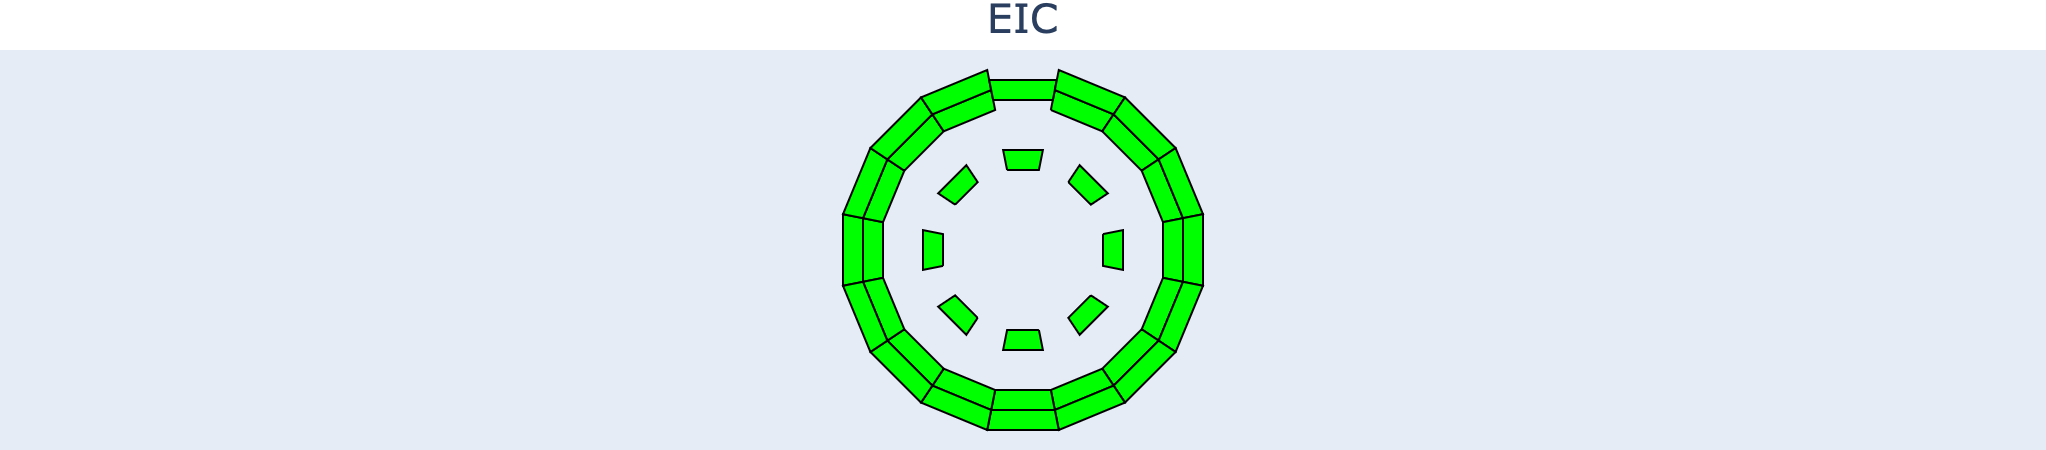

In [63]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_ei(fsm_df, 'C')

# Update the layout

fig.show()

In [37]:
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))

In [38]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [39]:
tmp_df

chamber    x0    y0
0    EIL4C01 -4.41  0.00
1    EIL4C03 -3.12  3.12
2    EIL4C05  0.00  4.41
3    EIL4C07  3.12  3.12
4    EIL4C09  4.41 -0.00
5   EIL4C011  3.12 -3.12
6   EIL4C013 -0.00 -4.41
7   EIL4C015 -3.12 -3.12
8    EEL1C01 -7.36  0.00
9    EES1C02 -6.80  2.81
10   EEL1C03 -5.20  5.20
11   EES1C04 -2.81  6.80
12   EES1C06  2.81  6.80
13   EEL1C07  5.20  5.20
14   EES1C08  6.80  2.81
15   EEL1C09  7.36 -0.00
16  EES1C010  6.80 -2.81
17  EEL1C011  5.20 -5.20
18  EES1C012  2.81 -6.80
19  EEL1C013 -0.00 -7.36
20  EES1C014 -2.81 -6.80
21  EEL1C015 -5.20 -5.20
22  EES1C016 -6.80 -2.81
23   EEL2C01 -8.34  0.00
24   EES2C02 -7.70  3.19
25   EEL2C03 -5.89  5.89
26   EES2C04 -3.19  7.70
27   EEL2C05  0.00  7.85
28   EES2C06  3.19  7.70
29   EEL2C07  5.89  5.89
30   EES2C08  7.70  3.19
31   EEL2C09  8.34 -0.00
32  EES2C010  7.70 -3.19
33  EEL2C011  5.89 -5.89
34  EES2C012  3.19 -7.70
35  EEL2C013 -0.00 -8.34
36  EES2C014 -3.19 -7.70
37  EEL2C015 -5.89 -5.89
38  EES2C016 -7.70 -3.19

In [40]:
# tmp_df.to_parquet('eic_coords.parquet')

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

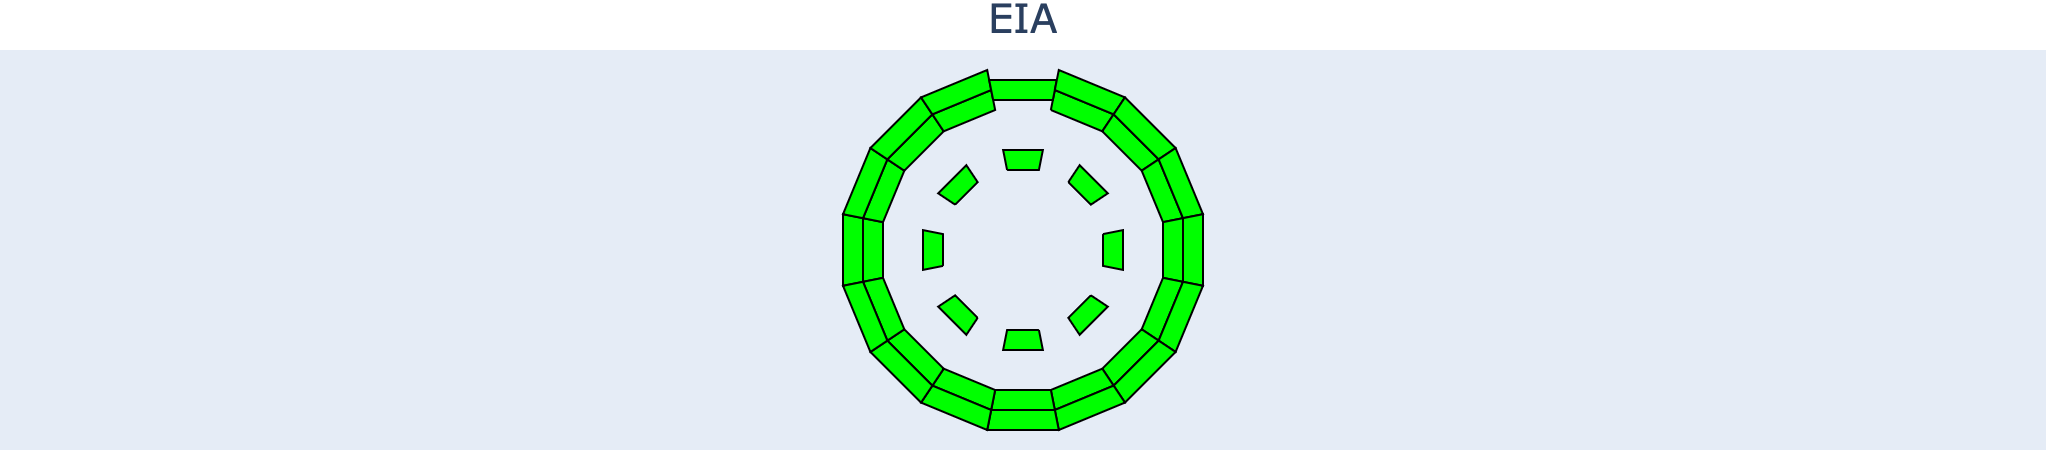

In [48]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_ei(fsm_df, 'A')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [49]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [50]:
tmp_df

chamber    x0    y0
0    EIL4A01 -4.41  0.00
1    EIL4A03 -3.12  3.12
2    EIL4A05  0.00  4.41
3    EIL4A07  3.12  3.12
4    EIL4A09  4.41 -0.00
5   EIL4A011  3.12 -3.12
6   EIL4A013 -0.00 -4.41
7   EIL4A015 -3.12 -3.12
8    EEL1A01 -7.36  0.00
9    EES1A02 -6.80  2.81
10   EEL1A03 -5.20  5.20
11   EES1A04 -2.81  6.80
12   EES1A06  2.81  6.80
13   EEL1A07  5.20  5.20
14   EES1A08  6.80  2.81
15   EEL1A09  7.36 -0.00
16  EES1A010  6.80 -2.81
17  EEL1A011  5.20 -5.20
18  EES1A012  2.81 -6.80
19  EEL1A013 -0.00 -7.36
20  EES1A014 -2.81 -6.80
21  EEL1A015 -5.20 -5.20
22  EES1A016 -6.80 -2.81
23   EEL2A01 -8.34  0.00
24   EES2A02 -7.70  3.19
25   EEL2A03 -5.89  5.89
26   EES2A04 -3.19  7.70
27   EEL2A05  0.00  7.85
28   EES2A06  3.19  7.70
29   EEL2A07  5.89  5.89
30   EES2A08  7.70  3.19
31   EEL2A09  8.34 -0.00
32  EES2A010  7.70 -3.19
33  EEL2A011  5.89 -5.89
34  EES2A012  3.19 -7.70
35  EEL2A013 -0.00 -8.34
36  EES2A014 -3.19 -7.70
37  EEL2A015 -5.89 -5.89
38  EES2A016 -7.70 -3.19

In [51]:
# tmp_df.to_parquet('eia_coords.parquet')

In [52]:
def plot_em(fsm_df, side):
    
    fig = go.Figure()
    
    center = np.array([0, 0])
    polygon_center_xs = []
    polygon_center_ys = []
    chamber_names = []
    radius_inner = 1.0
    radius_outer = 5.0
    num_sections = 16
    num_eta = 5
    angular_offset = np.pi / num_sections + np.pi

    # Draw the polygons
    for ring_index in range(num_eta):
        
        for segment_index in range(num_sections):

            polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
            # Calculate the polygon center
            polygon_center_x = np.mean([v[0] for v in polygon_vertices])
            polygon_center_y = np.mean([v[1] for v in polygon_vertices])

            polygon_center_xs.append(polygon_center_x)
            polygon_center_ys.append(polygon_center_y)

            # Get the chamber name
            if segment_index < 10:

                if segment_index % 2 != 0:
                    
                    chamber_name = f'EMS{ring_index+1}{side}0{segment_index+1}'

                else:

                    chamber_name = f'EML{ring_index+1}{side}0{segment_index+1}'

            else:
                
                if segment_index % 2 != 0:
                    
                    chamber_name = f'EMS{ring_index+1}{side}{segment_index+1}'

                else:

                    chamber_name = f'EML{ring_index+1}{side}{segment_index+1}'

            chamber_names.append(chamber_name)
                    
            tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
            list_of_errors = tmp_df['value'].values
        
            # Choose the color based on whether the chamber is in fsm_df
            if len(tmp_df) > 0:
                
                fillcolor = 'crimson'
                text = f'{chamber_name}: {list_of_errors}'
                
            else:
                
                fillcolor = 'lime'
                text = f'{chamber_name}: READY'

            # Create the polygon
            x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
            y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]

            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals,
                mode = 'lines',
                fill='toself',
                fillcolor=fillcolor,
                line=dict(color='black'),
            ))

            fig.add_trace(go.Scatter(
                x=[polygon_center_x], y=[polygon_center_y],
                marker_color = fillcolor,
                marker_size = 1,
                name=chamber_name,
                hoverinfo='text',
                text=text,
            ))

    # Update the layout
    fig.update_layout(
    title = {
        'text': f'EM{side}',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=450, width=450,
    margin=dict(l=0,r=0,b=0,t=50)
    )

    return fig, chamber_names, polygon_center_xs, polygon_center_ys

In [53]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_em(fsm_df, 'C')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

NameError: name 'num_sections' is not defined

In [ ]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [ ]:
tmp_df

In [45]:
# tmp_df.to_parquet('emc_coords.parquet')

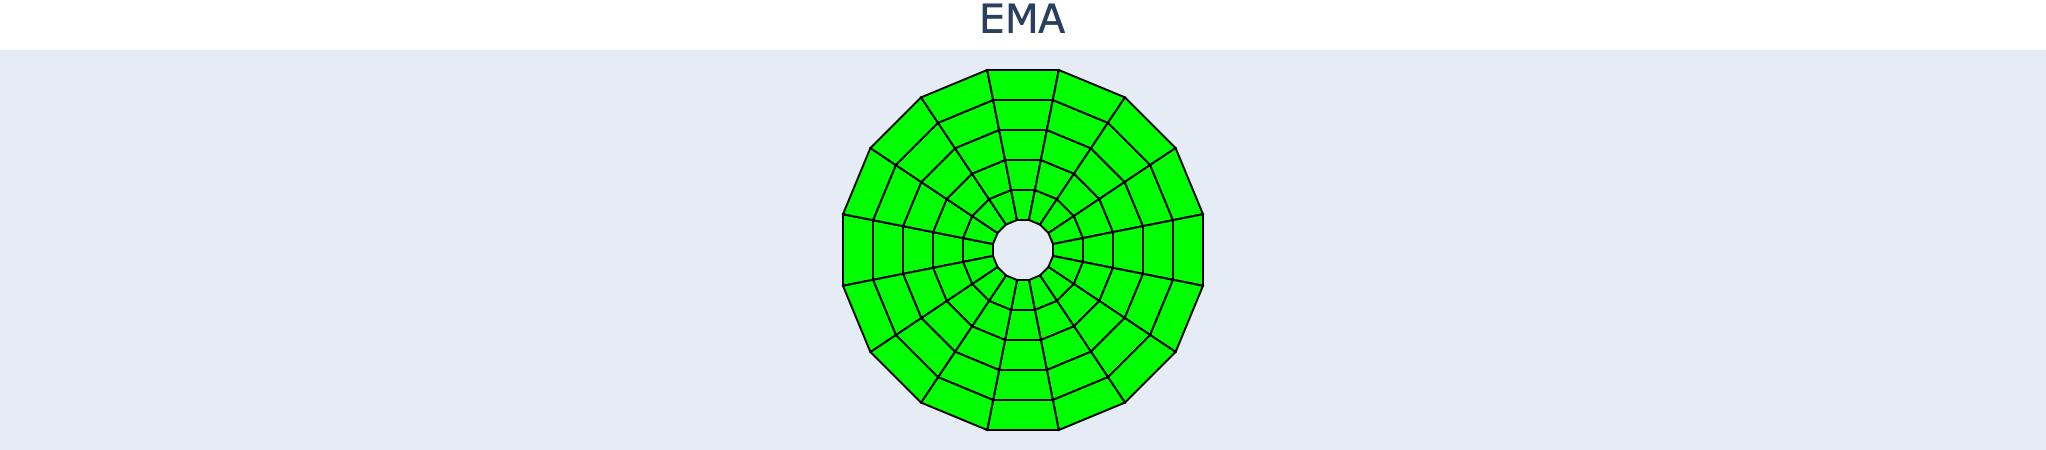

In [46]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_em(fsm_df, 'A')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [ ]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [ ]:
# tmp_df.to_parquet('ema_coords.parquet')

In [ ]:
def plot_eo(fsm_df, side):

    fig = go.Figure()

    polygon_center_xs = []
    polygon_center_ys = []
    chamber_names = []
    radius_inner = 1.0
    radius_outer = 6.0
    num_sections = 16
    num_eta = 6
    angular_offset = np.pi / num_sections + np.pi



    def get_polygon_vertices(ring_index, segment_index):
        start_angle = - 2 * np.pi * (segment_index - 1) / num_sections - angular_offset
        end_angle = - 2 * np.pi * (segment_index) / num_sections - angular_offset
        
        inner_radius = radius_inner + ring_index
        outer_radius = radius_inner + ring_index + 1

        v1 = get_vertex_coords(inner_radius, start_angle)
        v2 = get_vertex_coords(inner_radius, end_angle)
        v3 = get_vertex_coords(outer_radius, end_angle)
        v4 = get_vertex_coords(outer_radius, start_angle)
        
        return [v1, v2, v3, v4]

    # Draw the polygons
    for ring_index in range(num_eta):
        
        for segment_index in range(num_sections):
            
            polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
            # Calculate the polygon center
            polygon_center_x = np.mean([v[0] for v in polygon_vertices])
            polygon_center_y = np.mean([v[1] for v in polygon_vertices])

            polygon_center_xs.append(polygon_center_x)
            polygon_center_ys.append(polygon_center_y)

            # Get the chamber name
            if segment_index < 10:

                if segment_index % 2 != 0:
                    
                    chamber_name = f'EOS{ring_index+1}{side}0{segment_index+1}'

                else:

                    chamber_name = f'EOL{ring_index+1}{side}0{segment_index+1}'

            else:
                
                if segment_index % 2 != 0:
                    
                    chamber_name = f'EOS{ring_index+1}{side}{segment_index+1}'

                else:

                    chamber_name = f'EOL{ring_index+1}{side}{segment_index+1}'

            chamber_names.append(chamber_name)

            tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
            list_of_errors = tmp_df['value'].values
        
            # Choose the color based on whether the chamber is in fsm_df
            if len(tmp_df) > 0:
                
                fillcolor = 'crimson'
                text = f'{chamber_name}: {list_of_errors}'
                
            else:
                
                fillcolor = 'lime'
                text = f'{chamber_name}: READY'

            # Create the polygon
            x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
            y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]

            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals,
                mode = 'lines',
                fill='toself',
                fillcolor=fillcolor,
                line=dict(color='black'),
            ))

            fig.add_trace(go.Scatter(
                x=[polygon_center_x], y=[polygon_center_y],
                marker_color = fillcolor,
                marker_size = 1,
                name=chamber_name,
                hoverinfo='text',
                text=text,
            ))

    # Update the layout
    fig.update_layout(
    title = {
        'text': f'EO{side}',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=450, width=450,
    margin=dict(l=0,r=0,b=0,t=50)
    )

    return fig, chamber_names, polygon_center_xs, polygon_center_ys

In [ ]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_eo(fsm_df, 'C')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [ ]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [ ]:
tmp_df

In [ ]:
# tmp_df.to_parquet('eoc_coords.parquet')

In [ ]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_eo(fsm_df, 'A')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [ ]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [ ]:
# tmp_df.to_parquet('eoa_coords.parquet')

In [ ]:
a = '''             <area target="_self" alt="BIL1C01" title="BIL1C01" href="{{url_for('chamber')}}" coords="132,25,143,37" shape="rect" onclick = "JTAG_onclick('BIL1C01')">
					<area target="_self" alt="BIL2C01" title="BIL2C01" href="{{url_for('chamber')}}" coords="119,25,130,35" shape="rect" onclick = "JTAG_onclick('BIL2C01')">
					<area target="_self" alt="BIL3C01" title="BIL3C01" href="{{url_for('chamber')}}" coords="106,26,116,36" shape="rect" onclick = "JTAG_onclick('BIL3C01')">
					<area target="_self" alt="BIL4C01" title="BIL4C01" href="{{url_for('chamber')}}" coords="93,26,104,36" shape="rect" onclick = "JTAG_onclick('BIL4C01')">
					<area target="_self" alt="BIL5C01" title="BIL5C01" href="{{url_for('chamber')}}" coords="78,24,91,35" shape="rect" onclick = "JTAG_onclick('BIL5C01')">
					<area target="_self" alt="BIL6C01" title="BIL6C01" href="{{url_for('chamber')}}" coords="66,25,77,35" shape="rect" onclick = "JTAG_onclick('BIL6C01')">
					<area target="_self" alt="BIS1C02" title="BIS1C02" href="{{url_for('chamber')}}" coords="132,38,144,48" shape="rect" onclick = "JTAG_onclick('BIS1C02')">
					<area target="_self" alt="BIS2C02" title="BIS2C02" href="{{url_for('chamber')}}" coords="118,37,129,47" shape="rect" onclick = "JTAG_onclick('BIS2C02')">
					<area target="_self" alt="BIS3C02" title="BIS3C02" href="{{url_for('chamber')}}" coords="106,38,116,47" shape="rect" onclick = "JTAG_onclick('BIS3C02')">
					<area target="_self" alt="BIS4C02" title="BIS4C02" href="{{url_for('chamber')}}" coords="92,37,105,48" shape="rect" onclick = "JTAG_onclick('BIS4C02')">
					<area target="_self" alt="BIS5C02" title="BIS5C02" href="{{url_for('chamber')}}" coords="79,38,91,49" shape="rect" onclick = "JTAG_onclick('BIS5C02')">
					<area target="_self" alt="BIS6C02" title="BIS6C02" href="{{url_for('chamber')}}" coords="67,38,78,48" shape="rect" onclick = "JTAG_onclick('BIS6C02')">
					<area target="_self" alt="BIS7C02" title="BIS7C02" href="{{url_for('chamber')}}" coords="53,36,65,47" shape="rect" onclick = "JTAG_onclick('BIS7C02')">
					<area target="_self" alt="BIS8C02" title="BIS8C02" href="{{url_for('chamber')}}" coords="39,37,51,48" shape="rect" onclick = "JTAG_onclick('BIS8C02')">

					<area target="_self" alt="BIL1C03" title="BIL1C03" href="{{url_for('chamber')}}" coords="132,57,143,69" shape="rect" onclick = "JTAG_onclick('BIL1C03')">
					<area target="_self" alt="BIL2C03" title="BIL2C03" href="{{url_for('chamber')}}" coords="118,58,129,68" shape="rect" onclick = "JTAG_onclick('BIL2C03')">
					<area target="_self" alt="BIL3C03" title="BIL3C03" href="{{url_for('chamber')}}" coords="106,58,116,68" shape="rect" onclick = "JTAG_onclick('BIL3C03')">
					<area target="_self" alt="BIL4C03" title="BIL4C03" href="{{url_for('chamber')}}" coords="93,58,104,68" shape="rect" onclick = "JTAG_onclick('BIL4C03')">
					<area target="_self" alt="BIL5C03" title="BIL5C03" href="{{url_for('chamber')}}" coords="78,58,91,69" shape="rect" onclick = "JTAG_onclick('BIL5C03')">
					<area target="_self" alt="BIL6C03" title="BIL6C03" href="{{url_for('chamber')}}" coords="66,57,77,67" shape="rect" onclick = "JTAG_onclick('BIL6C03')">
					<area target="_self" alt="BIS1C04" title="BIS1C04" href="{{url_for('chamber')}}" coords="131,70,143,80" shape="rect" onclick = "JTAG_onclick('BIS1C04')">
					<area target="_self" alt="BIS2C04" title="BIS2C04" href="{{url_for('chamber')}}" coords="118,70,129,80" shape="rect" onclick = "JTAG_onclick('BIS2C04')">
					<area target="_self" alt="BIS3C04" title="BIS3C04" href="{{url_for('chamber')}}" coords="106,71,116,80" shape="rect" onclick = "JTAG_onclick('BIS3C04')">
					<area target="_self" alt="BIS4C04" title="BIS4C04" href="{{url_for('chamber')}}" coords="92,71,105,82" shape="rect" onclick = "JTAG_onclick('BIS4C04')">
					<area target="_self" alt="BIS5C04" title="BIS5C04" href="{{url_for('chamber')}}" coords="79,70,91,81" shape="rect" onclick = "JTAG_onclick('BIS5C04')">
					<area target="_self" alt="BIS6C04" title="BIS6C04" href="{{url_for('chamber')}}" coords="67,70,78,80" shape="rect" onclick = "JTAG_onclick('BIS6C04')">
					<area target="_self" alt="BIS7C04" title="BIS7C04" href="{{url_for('chamber')}}" coords="52,69,64,80" shape="rect" onclick = "JTAG_onclick('BIS7C04')">
					<area target="_self" alt="BIS8C04" title="BIS8C04" href="{{url_for('chamber')}}" coords="39,70,51,81" shape="rect" onclick = "JTAG_onclick('BIS8C04')">

					<area target="_self" alt="BIL1C05" title="BIL1C05" href="{{url_for('chamber')}}" coords="132,90,143,102" shape="rect" onclick = "JTAG_onclick('BIL1C05')">
					<area target="_self" alt="BIL2C05" title="BIL2C05" href="{{url_for('chamber')}}" coords="118,91,129,101" shape="rect" onclick = "JTAG_onclick('BIL2C05')">
					<area target="_self" alt="BIL3C05" title="BIL3C05" href="{{url_for('chamber')}}" coords="106,90,116,100" shape="rect" onclick = "JTAG_onclick('BIL3C05')">
					<area target="_self" alt="BIL4C05" title="BIL4C05" href="{{url_for('chamber')}}" coords="93,91,104,101" shape="rect" onclick = "JTAG_onclick('BIL4C05')">
					<area target="_self" alt="BIL5C05" title="BIL5C05" href="{{url_for('chamber')}}" coords="78,90,91,101" shape="rect" onclick = "JTAG_onclick('BIL5C05')">
					<area target="_self" alt="BIL6C05" title="BIL6C05" href="{{url_for('chamber')}}" coords="66,91,77,101" shape="rect" onclick = "JTAG_onclick('BIL6C05')">
					<area target="_self" alt="BIS1C06" title="BIS1C06" href="{{url_for('chamber')}}" coords="131,103,143,113" shape="rect" onclick = "JTAG_onclick('BIS1C06')">
					<area target="_self" alt="BIS2C06" title="BIS2C06" href="{{url_for('chamber')}}" coords="118,103,129,113" shape="rect" onclick = "JTAG_onclick('BIS2C06')">
					<area target="_self" alt="BIS3C06" title="BIS3C06" href="{{url_for('chamber')}}" coords="106,103,116,112" shape="rect" onclick = "JTAG_onclick('BIS3C06')">
					<area target="_self" alt="BIS4C06" title="BIS4C06" href="{{url_for('chamber')}}" coords="92,102,105,113" shape="rect" onclick = "JTAG_onclick('BIS4C06')">
					<area target="_self" alt="BIS5C06" title="BIS5C06" href="{{url_for('chamber')}}" coords="79,101,91,112" shape="rect" onclick = "JTAG_onclick('BIS5C06')">
					<area target="_self" alt="BIS6C06" title="BIS6C06" href="{{url_for('chamber')}}" coords="67,103,78,113" shape="rect" onclick = "JTAG_onclick('BIS6C06')">
					<area target="_self" alt="BIS7C06" title="BIS7C06" href="{{url_for('chamber')}}" coords="52,102,64,113" shape="rect" onclick = "JTAG_onclick('BIS7C06')">
					<area target="_self" alt="BIS8C06" title="BIS8C06" href="{{url_for('chamber')}}" coords="39,102,51,113" shape="rect" onclick = "JTAG_onclick('BIS8C06')">

					<area target="_self" alt="BIL1C07" title="BIL1C07" href="{{url_for('chamber')}}" coords="132,123,143,135" shape="rect" onclick = "JTAG_onclick('BIL1C07')">
					<area target="_self" alt="BIL2C07" title="BIL2C07" href="{{url_for('chamber')}}" coords="118,123,129,133" shape="rect" onclick = "JTAG_onclick('BIL2C07')">
					<area target="_self" alt="BIL3C07" title="BIL3C07" href="{{url_for('chamber')}}" coords="106,122,116,132" shape="rect" onclick = "JTAG_onclick('BIL3C07')">
					<area target="_self" alt="BIL4C07" title="BIL4C07" href="{{url_for('chamber')}}" coords="93,122,104,132" shape="rect" onclick = "JTAG_onclick('BIL4C07')">
					<area target="_self" alt="BIL5C07" title="BIL5C07" href="{{url_for('chamber')}}" coords="79,122,92,133" shape="rect" onclick = "JTAG_onclick('BIL5C07')">
					<area target="_self" alt="BIL6C07" title="BIL6C07" href="{{url_for('chamber')}}" coords="66,123,77,133" shape="rect" onclick = "JTAG_onclick('BIL6C07')">
					<area target="_self" alt="BIS1C08" title="BIS1C08" href="{{url_for('chamber')}}" coords="131,134,143,144" shape="rect" onclick = "JTAG_onclick('BIS1C08')">
					<area target="_self" alt="BIS2C08" title="BIS2C08" href="{{url_for('chamber')}}" coords="118,134,129,144" shape="rect" onclick = "JTAG_onclick('BIS2C08')">
					<area target="_self" alt="BIS3C08" title="BIS3C08" href="{{url_for('chamber')}}" coords="106,135,116,144" shape="rect" onclick = "JTAG_onclick('BIS3C08')">
					<area target="_self" alt="BIS4C08" title="BIS4C08" href="{{url_for('chamber')}}" coords="92,134,105,145" shape="rect" onclick = "JTAG_onclick('BIS4C08')">
					<area target="_self" alt="BIS5C08" title="BIS5C08" href="{{url_for('chamber')}}" coords="79,134,91,145" shape="rect" onclick = "JTAG_onclick('BIS5C08')">
					<area target="_self" alt="BIS6C08" title="BIS6C08" href="{{url_for('chamber')}}" coords="66,134,77,144" shape="rect" onclick = "JTAG_onclick('BIS6C08')">
					<area target="_self" alt="BIS7C08" title="BIS7C08" href="{{url_for('chamber')}}" coords="52,134,64,145" shape="rect" onclick = "JTAG_onclick('BIS7C08')">
					<area target="_self" alt="BIS8C08" title="BIS8C08" href="{{url_for('chamber')}}" coords="39,134,51,145" shape="rect" onclick = "JTAG_onclick('BIS8C08')">

					<area target="_self" alt="BIL1C09" title="BIL1C09" href="{{url_for('chamber')}}" coords="132,155,143,167" shape="rect" onclick = "JTAG_onclick('BIL1C09')">
					<area target="_self" alt="BIL2C09" title="BIL2C09" href="{{url_for('chamber')}}" coords="118,155,129,165" shape="rect" onclick = "JTAG_onclick('BIL2C09')">
					<area target="_self" alt="BIL3C09" title="BIL3C09" href="{{url_for('chamber')}}" coords="106,155,116,165" shape="rect" onclick = "JTAG_onclick('BIL3C09')">
					<area target="_self" alt="BIL4C09" title="BIL4C09" href="{{url_for('chamber')}}" coords="92,155,103,165" shape="rect" onclick = "JTAG_onclick('BIL4C09')">
					<area target="_self" alt="BIL5C09" title="BIL5C09" href="{{url_for('chamber')}}" coords="79,156,92,167" shape="rect" onclick = "JTAG_onclick('BIL5C09')">
					<area target="_self" alt="BIL6C09" title="BIL6C09" href="{{url_for('chamber')}}" coords="66,156,77,166" shape="rect" onclick = "JTAG_onclick('BIL6C09')">
					<area target="_self" alt="BIS1C10" title="BIS1C10" href="{{url_for('chamber')}}" coords="132,168,144,178" shape="rect" onclick = "JTAG_onclick('BIS1C10')">
					<area target="_self" alt="BIS2C10" title="BIS2C10" href="{{url_for('chamber')}}" coords="118,167,129,177" shape="rect" onclick = "JTAG_onclick('BIS2C10')">
					<area target="_self" alt="BIS3C10" title="BIS3C10" href="{{url_for('chamber')}}" coords="106,168,116,177" shape="rect" onclick = "JTAG_onclick('BIS3C10')">
					<area target="_self" alt="BIS4C10" title="BIS4C10" href="{{url_for('chamber')}}" coords="92,167,105,178" shape="rect" onclick = "JTAG_onclick('BIS4C10')">
					<area target="_self" alt="BIS5C10" title="BIS5C10" href="{{url_for('chamber')}}" coords="79,167,91,178" shape="rect" onclick = "JTAG_onclick('BIS5C10')">
					<area target="_self" alt="BIS6C10" title="BIS6C10" href="{{url_for('chamber')}}" coords="66,167,77,177" shape="rect" onclick = "JTAG_onclick('BIS6C10')">
					<area target="_self" alt="BIS7C10" title="BIS7C10" href="{{url_for('chamber')}}" coords="53,167,65,178" shape="rect" onclick = "JTAG_onclick('BIS7C10')">
					<area target="_self" alt="BIS8C10" title="BIS8C10" href="{{url_for('chamber')}}" coords="40,167,52,178" shape="rect" onclick = "JTAG_onclick('BIS8C10')">

					<area target="_self" alt="BIL1C13" title="BIL1C13" href="{{url_for('chamber')}}" coords="132,231,143,243" shape="rect" onclick = "JTAG_onclick('BIL1C13')">
					<area target="_self" alt="BIL2C13" title="BIL2C13" href="{{url_for('chamber')}}" coords="118,232,129,242" shape="rect" onclick = "JTAG_onclick('BIL2C13')">
					<area target="_self" alt="BIL3C13" title="BIL3C13" href="{{url_for('chamber')}}" coords="106,233,116,243" shape="rect" onclick = "JTAG_onclick('BIL3C13')">
					<area target="_self" alt="BIL4C13" title="BIL4C13" href="{{url_for('chamber')}}" coords="92,232,103,242" shape="rect" onclick = "JTAG_onclick('BIL4C13')">
					<area target="_self" alt="BIL5C13" title="BIL5C13" href="{{url_for('chamber')}}" coords="79,232,92,243" shape="rect" onclick = "JTAG_onclick('BIL5C13')">
					<area target="_self" alt="BIL6C13" title="BIL6C13" href="{{url_for('chamber')}}" coords="66,232,77,242" shape="rect" onclick = "JTAG_onclick('BIL6C13')">
					<area target="_self" alt="BIS1C14" title="BIS1C14" href="{{url_for('chamber')}}" coords="131,245,143,255" shape="rect" onclick = "JTAG_onclick('BIS1C14')">
					<area target="_self" alt="BIS2C14" title="BIS2C14" href="{{url_for('chamber')}}" coords="118,244,129,254" shape="rect" onclick = "JTAG_onclick('BIS2C14')">
					<area target="_self" alt="BIS3C14" title="BIS3C14" href="{{url_for('chamber')}}" coords="106,245,116,254" shape="rect" onclick = "JTAG_onclick('BIS3C14')">
					<area target="_self" alt="BIS4C14" title="BIS4C14" href="{{url_for('chamber')}}" coords="92,244,105,255" shape="rect" onclick = "JTAG_onclick('BIS4C14')">
					<area target="_self" alt="BIS5C14" title="BIS5C14" href="{{url_for('chamber')}}" coords="80,243,92,254" shape="rect" onclick = "JTAG_onclick('BIS5C14')">
					<area target="_self" alt="BIS6C14" title="BIS6C14" href="{{url_for('chamber')}}" coords="67,245,78,255" shape="rect" onclick = "JTAG_onclick('BIS6C14')">
					<area target="_self" alt="BIS7C14" title="BIS7C14" href="{{url_for('chamber')}}" coords="53,244,65,255" shape="rect" onclick = "JTAG_onclick('BIS7C14')">
					<area target="_self" alt="BIS8C14" title="BIS8C14" href="{{url_for('chamber')}}" coords="39,244,51,255" shape="rect" onclick = "JTAG_onclick('BIS8C14')">

					<area target="_self" alt="BIS1C12" title="BIS1C12" href="{{url_for('chamber')}}" coords="132,211,144,221" shape="rect" onclick = "JTAG_onclick('BIS1C12')">
					<area target="_self" alt="BIS2C12" title="BIS2C12" href="{{url_for('chamber')}}" coords="119,211,130,221" shape="rect" onclick = "JTAG_onclick('BIS2C12')">
					<area target="_self" alt="BIS3C12" title="BIS3C12" href="{{url_for('chamber')}}" coords="106,212,116,221" shape="rect" onclick = "JTAG_onclick('BIS3C12')">
					<area target="_self" alt="BIS4C12" title="BIS4C12" href="{{url_for('chamber')}}" coords="92,211,105,222" shape="rect" onclick = "JTAG_onclick('BIS4C12')">
					<area target="_self" alt="BIS5C12" title="BIS5C12" href="{{url_for('chamber')}}" coords="79,211,91,222" shape="rect" onclick = "JTAG_onclick('BIS5C12')">
					<area target="_self" alt="BIS6C12" title="BIS6C12" href="{{url_for('chamber')}}" coords="67,211,78,221" shape="rect" onclick = "JTAG_onclick('BIS6C12')">
					<area target="_self" alt="BIS7C12" title="BIS7C12" href="{{url_for('chamber')}}" coords="53,211,65,222" shape="rect" onclick = "JTAG_onclick('BIS7C12')">
					<area target="_self" alt="BIS8C12" title="BIS8C12" href="{{url_for('chamber')}}" coords="40,212,52,223" shape="rect" onclick = "JTAG_onclick('BIS8C12')">
					<area target="_self" alt="BIR1C11" title="BIR1C11" href="{{url_for('chamber')}}" coords="132,200,143,209" shape="rect" onclick = "JTAG_onclick('BIR1C11')">
					<area target="_self" alt="BIR2C11" title="BIR2C11" href="{{url_for('chamber')}}" coords="119,200,130,209" shape="rect" onclick = "JTAG_onclick('BIR2C11')">
					<area target="_self" alt="BIR3C11" title="BIR3C11" href="{{url_for('chamber')}}" coords="105,200,116,210" shape="rect" onclick = "JTAG_onclick('BIR3C11')">
					<area target="_self" alt="BIR4C11" title="BIR4C11" href="{{url_for('chamber')}}" coords="92,200,104,210" shape="rect" onclick = "JTAG_onclick('BIR4C11')">
					<area target="_self" alt="BIR5C11" title="BIR5C11" href="{{url_for('chamber')}}" coords="79,200,91,209" shape="rect" onclick = "JTAG_onclick('BIR5C11')">
					<area target="_self" alt="BIR6C11" title="BIR6C11" href="{{url_for('chamber')}}" coords="66,200,78,210" shape="rect" onclick = "JTAG_onclick('BIR6C11')">
					<area target="_self" alt="BIM1C11" title="BIM1C11" href="{{url_for('chamber')}}" coords="132,187,143,197" shape="rect" onclick = "JTAG_onclick('BIM1C11')">
					<area target="_self" alt="BIM2C11" title="BIM2C11" href="{{url_for('chamber')}}" coords="118,188,130,198" shape="rect" onclick = "JTAG_onclick('BIM2C11')">
					<area target="_self" alt="BIM3C11" title="BIM3C11" href="{{url_for('chamber')}}" coords="105,187,117,199" shape="rect" onclick = "JTAG_onclick('BIM3C11')">
					<area target="_self" alt="BIM4C11" title="BIM4C11" href="{{url_for('chamber')}}" coords="92,187,104,198" shape="rect" onclick = "JTAG_onclick('BIM4C11')">
					<area target="_self" alt="BIM5C11" title="BIM5C11" href="{{url_for('chamber')}}" coords="78,186,90,197" shape="rect" onclick = "JTAG_onclick('BIM5C11')">

					<area target="_self" alt="BIS1C16" title="BIS1C16" href="{{url_for('chamber')}}" coords="132,288,144,298" shape="rect" onclick = "JTAG_onclick('BIS1C16')">
					<area target="_self" alt="BIS2C16" title="BIS2C16" href="{{url_for('chamber')}}" coords="119,289,130,299" shape="rect" onclick = "JTAG_onclick('BIS2C16')">
					<area target="_self" alt="BIS3C16" title="BIS3C16" href="{{url_for('chamber')}}" coords="106,289,116,298" shape="rect" onclick = "JTAG_onclick('BIS3C16')">
					<area target="_self" alt="BIS4C16" title="BIS4C16" href="{{url_for('chamber')}}" coords="92,287,105,298" shape="rect" onclick = "JTAG_onclick('BIS4C16')">
					<area target="_self" alt="BIS5C16" title="BIS5C16" href="{{url_for('chamber')}}" coords="80,288,92,299" shape="rect" onclick = "JTAG_onclick('BIS5C16')">
					<area target="_self" alt="BIS6C16" title="BIS6C16" href="{{url_for('chamber')}}" coords="66,288,77,298" shape="rect" onclick = "JTAG_onclick('BIS6C16')">
					<area target="_self" alt="BIS7C16" title="BIS7C16" href="{{url_for('chamber')}}" coords="53,288,65,299" shape="rect" onclick = "JTAG_onclick('BIS7C16')">
					<area target="_self" alt="BIS8C16" title="BIS8C16" href="{{url_for('chamber')}}" coords="40,287,52,298" shape="rect" onclick = "JTAG_onclick('BIS8C16')">
					<area target="_self" alt="BIR1C15" title="BIR1C15" href="{{url_for('chamber')}}" coords="132,265,143,274" shape="rect" onclick = "JTAG_onclick('BIR1C15')">
					<area target="_self" alt="BIR2C15" title="BIR2C15" href="{{url_for('chamber')}}" coords="118,265,129,274" shape="rect" onclick = "JTAG_onclick('BIR2C15')">
					<area target="_self" alt="BIR3C15" title="BIR3C15" href="{{url_for('chamber')}}" coords="105,264,116,274" shape="rect" onclick = "JTAG_onclick('BIR3C15')">
					<area target="_self" alt="BIR4C15" title="BIR4C15" href="{{url_for('chamber')}}" coords="92,265,104,275" shape="rect" onclick = "JTAG_onclick('BIR4C15')">
					<area target="_self" alt="BIR5C15" title="BIR5C15" href="{{url_for('chamber')}}" coords="79,265,91,274" shape="rect" onclick = "JTAG_onclick('BIR5C15')">
					<area target="_self" alt="BIR6C15" title="BIR6C15" href="{{url_for('chamber')}}" coords="66,265,78,275" shape="rect" onclick = "JTAG_onclick('BIR6C15')">
					<area target="_self" alt="BIM1C15" title="BIM1C15" href="{{url_for('chamber')}}" coords="132,276,143,286" shape="rect" onclick = "JTAG_onclick('BIM1C15')">
					<area target="_self" alt="BIM2C15" title="BIM2C15" href="{{url_for('chamber')}}" coords="117,276,129,286" shape="rect" onclick = "JTAG_onclick('BIM2C15')">
					<area target="_self" alt="BIM3C15" title="BIM3C15" href="{{url_for('chamber')}}" coords="106,275,118,287" shape="rect" onclick = "JTAG_onclick('BIM3C15')">
					<area target="_self" alt="BIM4C15" title="BIM4C15" href="{{url_for('chamber')}}" coords="92,276,104,287" shape="rect" onclick = "JTAG_onclick('BIM4C15')">
					<area target="_self" alt="BIM5C15" title="BIM5C15" href="{{url_for('chamber')}}" coords="78,276,90,287" shape="rect" onclick = "JTAG_onclick('BIM5C15')">

					<area target="_self" alt="BIS1A16" title="BIS1A16" href="{{url_for('chamber')}}" coords="157,289,169,299" shape="rect" onclick = "JTAG_onclick('BIS1A16')">
					<area target="_self" alt="BIS2A16" title="BIS2A16" href="{{url_for('chamber')}}" coords="171,289,182,299" shape="rect" onclick = "JTAG_onclick('BIS2A16')">
					<area target="_self" alt="BIS3A16" title="BIS3A16" href="{{url_for('chamber')}}" coords="184,289,195,299" shape="rect" onclick = "JTAG_onclick('BIS3A16')">
					<area target="_self" alt="BIS4A16" title="BIS4A16" href="{{url_for('chamber')}}" coords="195,288,208,299" shape="rect" onclick = "JTAG_onclick('BIS4A16')">
					<area target="_self" alt="BIS5A16" title="BIS5A16" href="{{url_for('chamber')}}" coords="210,287,222,298" shape="rect" onclick = "JTAG_onclick('BIS5A16')">
					<area target="_self" alt="BIS6A16" title="BIS6A16" href="{{url_for('chamber')}}" coords="223,289,234,299" shape="rect" onclick = "JTAG_onclick('BIS6A16')">
					<area target="_self" alt="BIR1A15" title="BIR1A15" href="{{url_for('chamber')}}" coords="157,265,168,274" shape="rect" onclick = "JTAG_onclick('BIR1A15')">
					<area target="_self" alt="BIR2A15" title="BIR2A15" href="{{url_for('chamber')}}" coords="171,265,182,274" shape="rect" onclick = "JTAG_onclick('BIR2A15')">
					<area target="_self" alt="BIR3A15" title="BIR3A15" href="{{url_for('chamber')}}" coords="184,264,195,274" shape="rect" onclick = "JTAG_onclick('BIR3A15')">
					<area target="_self" alt="BIR4A15" title="BIR4A15" href="{{url_for('chamber')}}" coords="196,265,208,275" shape="rect" onclick = "JTAG_onclick('BIR4A15')">
					<area target="_self" alt="BIR5A15" title="BIR5A15" href="{{url_for('chamber')}}" coords="208,265,220,274" shape="rect" onclick = "JTAG_onclick('BIR5A15')">
					<area target="_self" alt="BIR6A15" title="BIR6A15" href="{{url_for('chamber')}}" coords="223,265,235,275" shape="rect" onclick = "JTAG_onclick('BIR6A15')">
					<area target="_self" alt="BIM1A15" title="BIM1A15" href="{{url_for('chamber')}}" coords="157,276,168,286" shape="rect" onclick = "JTAG_onclick('BIM1A15')">
					<area target="_self" alt="BIM2A15" title="BIM2A15" href="{{url_for('chamber')}}" coords="171,276,183,286" shape="rect" onclick = "JTAG_onclick('BIM2A15')">
					<area target="_self" alt="BIM3A15" title="BIM3A15" href="{{url_for('chamber')}}" coords="183,276,195,288" shape="rect" onclick = "JTAG_onclick('BIM3A15')">
					<area target="_self" alt="BIM4A15" title="BIM4A15" href="{{url_for('chamber')}}" coords="197,276,209,287" shape="rect" onclick = "JTAG_onclick('BIM4A15')">
					<area target="_self" alt="BIM5A15" title="BIM5A15" href="{{url_for('chamber')}}" coords="209,276,221,287" shape="rect" onclick = "JTAG_onclick('BIM5A15')">

					<area target="_self" alt="BIS1A12" title="BIS1A12" href="{{url_for('chamber')}}" coords="157,212,169,222" shape="rect" onclick = "JTAG_onclick('BIS1A12')">
					<area target="_self" alt="BIS2A12" title="BIS2A12" href="{{url_for('chamber')}}" coords="171,212,182,222" shape="rect" onclick = "JTAG_onclick('BIS2A12')">
					<area target="_self" alt="BIS3A12" title="BIS3A12" href="{{url_for('chamber')}}" coords="184,222,195,212" shape="rect" onclick = "JTAG_onclick('BIS3A12')">
					<area target="_self" alt="BIS4A12" title="BIS4A12" href="{{url_for('chamber')}}" coords="196,211,209,222" shape="rect" onclick = "JTAG_onclick('BIS4A12')">
					<area target="_self" alt="BIS5A12" title="BIS5A12" href="{{url_for('chamber')}}" coords="210,210,222,221" shape="rect" onclick = "JTAG_onclick('BIS5A12')">
					<area target="_self" alt="BIS6A12" title="BIS6A12" href="{{url_for('chamber')}}" coords="223,212,234,222" shape="rect" onclick = "JTAG_onclick('BIS6A12')">
					<area target="_self" alt="BIR1A11" title="BIR1A11" href="{{url_for('chamber')}}" coords="157,200,168,209" shape="rect" onclick = "JTAG_onclick('BIR1A11')">
					<area target="_self" alt="BIR2A11" title="BIR2A11" href="{{url_for('chamber')}}" coords="171,200,182,209" shape="rect" onclick = "JTAG_onclick('BIR2A11')">
					<area target="_self" alt="BIR3A11" title="BIR3A11" href="{{url_for('chamber')}}" coords="184,200,195,210" shape="rect" onclick = "JTAG_onclick('BIR3A11')">
					<area target="_self" alt="BIR4A11" title="BIR4A11" href="{{url_for('chamber')}}" coords="197,200,209,210" shape="rect" onclick = "JTAG_onclick('BIR4A11')">
					<area target="_self" alt="BIR5A11" title="BIR5A11" href="{{url_for('chamber')}}" coords="210,200,222,209" shape="rect" onclick = "JTAG_onclick('BIR5A11')">
					<area target="_self" alt="BIR6A11" title="BIR6A11" href="{{url_for('chamber')}}" coords="223,200,235,210" shape="rect" onclick = "JTAG_onclick('BIR6A11')">
					<area target="_self" alt="BIM1A11" title="BIM1A11" href="{{url_for('chamber')}}" coords="157,187,168,197" shape="rect" onclick = "JTAG_onclick('BIM1A11')">
					<area target="_self" alt="BIM2A11" title="BIM2A11" href="{{url_for('chamber')}}" coords="170,187,182,197" shape="rect" onclick = "JTAG_onclick('BIM2A11')">
					<area target="_self" alt="BIM3A11" title="BIM3A11" href="{{url_for('chamber')}}" coords="184,186,196,198" shape="rect" onclick = "JTAG_onclick('BIM3A11')">
					<area target="_self" alt="BIM4A11" title="BIM4A11" href="{{url_for('chamber')}}" coords="196,187,208,198" shape="rect" onclick = "JTAG_onclick('BIM4A11')">
					<area target="_self" alt="BIM5A11" title="BIM5A11" href="{{url_for('chamber')}}" coords="210,187,222,198" shape="rect" onclick = "JTAG_onclick('BIM5A11')">

					<area target="_self" alt="BIS1A02" title="BIS1A02" href="{{url_for('chamber')}}" coords="157,37,169,47" shape="rect" onclick = "JTAG_onclick('BIS1A02')">
					<area target="_self" alt="BIS2A02" title="BIS2A02" href="{{url_for('chamber')}}" coords="171,37,182,47" shape="rect" onclick = "JTAG_onclick('BIS2A02')">
					<area target="_self" alt="BIS3A02" title="BIS3A02" href="{{url_for('chamber')}}" coords="184,48,195,38" shape="rect" onclick = "JTAG_onclick('BIS3A02')">
					<area target="_self" alt="BIS4A02" title="BIS4A02" href="{{url_for('chamber')}}" coords="196,37,209,48" shape="rect" onclick = "JTAG_onclick('BIS4A02')">
					<area target="_self" alt="BIS5A02" title="BIS5A02" href="{{url_for('chamber')}}" coords="210,37,222,48" shape="rect" onclick = "JTAG_onclick('BIS5A02')">
					<area target="_self" alt="BIS6A02" title="BIS6A02" href="{{url_for('chamber')}}" coords="223,37,234,47" shape="rect" onclick = "JTAG_onclick('BIS6A02')">
					<area target="_self" alt="BIL1A01" title="BIL1A01" href="{{url_for('chamber')}}" coords="158,26,169,36" shape="rect" onclick = "JTAG_onclick('BIL1A01')">
					<area target="_self" alt="BIL2A01" title="BIL2A01" href="{{url_for('chamber')}}" coords="171,25,182,36" shape="rect" onclick = "JTAG_onclick('BIL2A01')">
					<area target="_self" alt="BIL3A01" title="BIL3A01" href="{{url_for('chamber')}}" coords="184,25,195,36" shape="rect" onclick = "JTAG_onclick('BIL3A01')">
					<area target="_self" alt="BIL4A01" title="BIL4A01" href="{{url_for('chamber')}}" coords="197,26,208,36" shape="rect" onclick = "JTAG_onclick('BIL4A01')">
					<area target="_self" alt="BIL5A01" title="BIL5A01" href="{{url_for('chamber')}}" coords="210,26,221,36" shape="rect" onclick = "JTAG_onclick('BIL5A01')">
					<area target="_self" alt="BIL6A01" title="BIL6A01" href="{{url_for('chamber')}}" coords="223,26,234,36" shape="rect" onclick = "JTAG_onclick('BIL6A01')">

					<area target="_self" alt="BIS1A04" title="BIS1A04" href="{{url_for('chamber')}}" coords="157,70,169,80" shape="rect" onclick = "JTAG_onclick('BIS1A04')">
					<area target="_self" alt="BIS2A04" title="BIS2A04" href="{{url_for('chamber')}}" coords="171,70,182,80" shape="rect" onclick = "JTAG_onclick('BIS2A04')">
					<area target="_self" alt="BIS3A04" title="BIS3A04" href="{{url_for('chamber')}}" coords="184,81,195,71" shape="rect" onclick = "JTAG_onclick('BIS3A04')">
					<area target="_self" alt="BIS4A04" title="BIS4A04" href="{{url_for('chamber')}}" coords="196,69,209,80" shape="rect" onclick = "JTAG_onclick('BIS4A04')">
					<area target="_self" alt="BIS5A04" title="BIS5A04" href="{{url_for('chamber')}}" coords="210,70,222,81" shape="rect" onclick = "JTAG_onclick('BIS5A04')">
					<area target="_self" alt="BIS6A04" title="BIS6A04" href="{{url_for('chamber')}}" coords="223,70,234,80" shape="rect" onclick = "JTAG_onclick('BIS6A04')">
					<area target="_self" alt="BIL1A03" title="BIL1A03" href="{{url_for('chamber')}}" coords="158,57,169,67" shape="rect" onclick = "JTAG_onclick('BIL1A03')">
					<area target="_self" alt="BIL2A03" title="BIL2A03" href="{{url_for('chamber')}}" coords="171,58,182,69" shape="rect" onclick = "JTAG_onclick('BIL2A03')">
					<area target="_self" alt="BIL3A03" title="BIL3A03" href="{{url_for('chamber')}}" coords="184,57,195,68" shape="rect" onclick = "JTAG_onclick('BIL3A03')">
					<area target="_self" alt="BIL4A03" title="BIL4A03" href="{{url_for('chamber')}}" coords="197,58,208,68" shape="rect" onclick = "JTAG_onclick('BIL4A03')">
					<area target="_self" alt="BIL5A03" title="BIL5A03" href="{{url_for('chamber')}}" coords="210,57,221,67" shape="rect" onclick = "JTAG_onclick('BIL5A03')">
					<area target="_self" alt="BIL6A03" title="BIL6A03" href="{{url_for('chamber')}}" coords="222,57,233,67" shape="rect" onclick = "JTAG_onclick('BIL6A03')">

					<area target="_self" alt="BIS1A06" title="BIS1A06" href="{{url_for('chamber')}}" coords="157,102,169,112" shape="rect" onclick = "JTAG_onclick('BIS1A06')">
					<area target="_self" alt="BIS2A06" title="BIS2A06" href="{{url_for('chamber')}}" coords="171,103,182,113" shape="rect" onclick = "JTAG_onclick('BIS2A06')">
					<area target="_self" alt="BIS3A06" title="BIS3A06" href="{{url_for('chamber')}}" coords="184,113,195,103" shape="rect" onclick = "JTAG_onclick('BIS3A06')">
					<area target="_self" alt="BIS4A06" title="BIS4A06" href="{{url_for('chamber')}}" coords="196,101,209,112" shape="rect" onclick = "JTAG_onclick('BIS4A06')">
					<area target="_self" alt="BIS5A06" title="BIS5A06" href="{{url_for('chamber')}}" coords="210,102,222,113" shape="rect" onclick = "JTAG_onclick('BIS5A06')">
					<area target="_self" alt="BIS6A06" title="BIS6A06" href="{{url_for('chamber')}}" coords="223,102,234,112" shape="rect" onclick = "JTAG_onclick('BIS6A06')">
					<area target="_self" alt="BIL1A05" title="BIL1A05" href="{{url_for('chamber')}}" coords="158,90,169,100" shape="rect" onclick = "JTAG_onclick('BIL1A05')">
					<area target="_self" alt="BIL2A05" title="BIL2A05" href="{{url_for('chamber')}}" coords="171,91,182,102" shape="rect" onclick = "JTAG_onclick('BIL2A05')">
					<area target="_self" alt="BIL3A05" title="BIL3A05" href="{{url_for('chamber')}}" coords="184,90,195,101" shape="rect" onclick = "JTAG_onclick('BIL3A05')">
					<area target="_self" alt="BIL4A05" title="BIL4A05" href="{{url_for('chamber')}}" coords="196,90,207,100" shape="rect" onclick = "JTAG_onclick('BIL4A05')">
					<area target="_self" alt="BIL5A05" title="BIL5A05" href="{{url_for('chamber')}}" coords="209,91,220,101" shape="rect" onclick = "JTAG_onclick('BIL5A05')">
					<area target="_self" alt="BIL6A05" title="BIL6A05" href="{{url_for('chamber')}}" coords="222,91,233,101" shape="rect" onclick = "JTAG_onclick('BIL6A05')">

					<area target="_self" alt="BIS1A08" title="BIS1A08" href="{{url_for('chamber')}}" coords="157,135,169,145" shape="rect" onclick = "JTAG_onclick('BIS1A08')">
					<area target="_self" alt="BIS2A08" title="BIS2A08" href="{{url_for('chamber')}}" coords="170,134,181,144" shape="rect" onclick = "JTAG_onclick('BIS2A08')">
					<area target="_self" alt="BIS3A08" title="BIS3A08" href="{{url_for('chamber')}}" coords="184,145,195,135" shape="rect" onclick = "JTAG_onclick('BIS3A08')">
					<area target="_self" alt="BIS4A08" title="BIS4A08" href="{{url_for('chamber')}}" coords="196,134,209,145" shape="rect" onclick = "JTAG_onclick('BIS4A08')">
					<area target="_self" alt="BIS5A08" title="BIS5A08" href="{{url_for('chamber')}}" coords="210,135,222,146" shape="rect" onclick = "JTAG_onclick('BIS5A08')">
					<area target="_self" alt="BIS6A08" title="BIS6A08" href="{{url_for('chamber')}}" coords="223,135,234,145" shape="rect" onclick = "JTAG_onclick('BIS6A08')">
					<area target="_self" alt="BIL1A07" title="BIL1A07" href="{{url_for('chamber')}}" coords="157,123,168,133" shape="rect" onclick = "JTAG_onclick('BIL1A07')">
					<area target="_self" alt="BIL2A07" title="BIL2A07" href="{{url_for('chamber')}}" coords="170,122,181,133" shape="rect" onclick = "JTAG_onclick('BIL2A07')">
					<area target="_self" alt="BIL3A07" title="BIL3A07" href="{{url_for('chamber')}}" coords="183,122,194,133" shape="rect" onclick = "JTAG_onclick('BIL3A07')">
					<area target="_self" alt="BIL4A07" title="BIL4A07" href="{{url_for('chamber')}}" coords="196,122,207,132" shape="rect" onclick = "JTAG_onclick('BIL4A07')">
					<area target="_self" alt="BIL5A07" title="BIL5A07" href="{{url_for('chamber')}}" coords="209,123,220,133" shape="rect" onclick = "JTAG_onclick('BIL5A07')">
					<area target="_self" alt="BIL6A07" title="BIL6A07" href="{{url_for('chamber')}}" coords="222,123,233,133" shape="rect" onclick = "JTAG_onclick('BIL6A07')">

					<area target="_self" alt="BIS1A10" title="BIS1A10" href="{{url_for('chamber')}}" coords="157,167,169,177" shape="rect" onclick = "JTAG_onclick('BIS1A10')">
					<area target="_self" alt="BIS2A10" title="BIS2A10" href="{{url_for('chamber')}}" coords="170,167,181,177" shape="rect" onclick = "JTAG_onclick('BIS2A10')">
					<area target="_self" alt="BIS3A10" title="BIS3A10" href="{{url_for('chamber')}}" coords="184,177,195,167" shape="rect" onclick = "JTAG_onclick('BIS3A10')">
					<area target="_self" alt="BIS4A10" title="BIS4A10" href="{{url_for('chamber')}}" coords="196,166,209,177" shape="rect" onclick = "JTAG_onclick('BIS4A10')">
					<area target="_self" alt="BIS5A10" title="BIS5A10" href="{{url_for('chamber')}}" coords="210,166,222,177" shape="rect" onclick = "JTAG_onclick('BIS5A10')">
					<area target="_self" alt="BIS6A10" title="BIS6A10" href="{{url_for('chamber')}}" coords="222,168,233,178" shape="rect" onclick = "JTAG_onclick('BIS6A10')">
					<area target="_self" alt="BIL1A09" title="BIL1A09" href="{{url_for('chamber')}}" coords="157,155,168,165" shape="rect" onclick = "JTAG_onclick('BIL1A09')">
					<area target="_self" alt="BIL2A09" title="BIL2A09" href="{{url_for('chamber')}}" coords="170,155,181,166" shape="rect" onclick = "JTAG_onclick('BIL2A09')">
					<area target="_self" alt="BIL3A09" title="BIL3A09" href="{{url_for('chamber')}}" coords="183,155,194,166" shape="rect" onclick = "JTAG_onclick('BIL3A09')">
					<area target="_self" alt="BIL4A09" title="BIL4A09" href="{{url_for('chamber')}}" coords="196,155,207,165" shape="rect" onclick = "JTAG_onclick('BIL4A09')">
					<area target="_self" alt="BIL5A09" title="BIL5A09" href="{{url_for('chamber')}}" coords="209,155,220,165" shape="rect" onclick = "JTAG_onclick('BIL5A09')">
					<area target="_self" alt="BIL6A09" title="BIL6A09" href="{{url_for('chamber')}}" coords="222,156,233,166" shape="rect" onclick = "JTAG_onclick('BIL6A09')">

					<area target="_self" alt="BIS1A14" title="BIS1A14" href="{{url_for('chamber')}}" coords="157,244,169,254" shape="rect" onclick = "JTAG_onclick('BIS1A14')">
					<area target="_self" alt="BIS2A14" title="BIS2A14" href="{{url_for('chamber')}}" coords="170,245,181,255" shape="rect" onclick = "JTAG_onclick('BIS2A14')">
					<area target="_self" alt="BIS3A14" title="BIS3A14" href="{{url_for('chamber')}}" coords="184,254,195,244" shape="rect" onclick = "JTAG_onclick('BIS3A14')">
					<area target="_self" alt="BIS4A14" title="BIS3A14" href="{{url_for('chamber')}}" coords="195,244,208,255" shape="rect" onclick = "JTAG_onclick('BIS3A14')">
					<area target="_self" alt="BIS5A14" title="BIS5A14" href="{{url_for('chamber')}}" coords="209,244,221,255" shape="rect" onclick = "JTAG_onclick('BIS5A14')">
					<area target="_self" alt="BIS6A14" title="BIS6A14" href="{{url_for('chamber')}}" coords="223,244,234,254" shape="rect" onclick = "JTAG_onclick('BIS6A14')">
					<area target="_self" alt="BIL1A13" title="BIL1A13" href="{{url_for('chamber')}}" coords="158,232,169,242" shape="rect" onclick = "JTAG_onclick('BIL1A13')">
					<area target="_self" alt="BIL2A13" title="BIL2A13" href="{{url_for('chamber')}}" coords="170,232,181,243" shape="rect" onclick = "JTAG_onclick('BIL2A13')">
					<area target="_self" alt="BIL3A13" title="BIL3A13" href="{{url_for('chamber')}}" coords="184,232,195,243" shape="rect" onclick = "JTAG_onclick('BIL3A13')">
					<area target="_self" alt="BIL4A13" title="BIL4A13" href="{{url_for('chamber')}}" coords="196,232,207,242" shape="rect" onclick = "JTAG_onclick('BIL4A13')">
					<area target="_self" alt="BIL5A13" title="BIL5A13" href="{{url_for('chamber')}}" coords="209,233,220,243" shape="rect" onclick = "JTAG_onclick('BIL5A13')">
					<area target="_self" alt="BIL6A13" title="BIL6A13" href="{{url_for('chamber')}}" coords="223,233,234,243" shape="rect" onclick = "JTAG_onclick('BIL6A13')">

					<area target="_self" alt="BEE1C02" title="BEE1C02" href="{{url_for('chamber')}}" coords="14,37,26,48" shape="rect" onclick = "JTAG_onclick('BEE1C02')">
					<area target="_self" alt="BEE2C02" title="BEE2C02" href="{{url_for('chamber')}}" coords="1,38,12,49" shape="rect" onclick = "JTAG_onclick('BEE2C02')">
					<area target="_self" alt="BEE1C04" title="BEE1C04" href="{{url_for('chamber')}}" coords="14,70,26,81" shape="rect" onclick = "JTAG_onclick('BEE1C04')">
					<area target="_self" alt="BEE2C04" title="BEE2C04" href="{{url_for('chamber')}}" coords="1,70,12,81" shape="rect" onclick = "JTAG_onclick('BEE2C04')">
					<area target="_self" alt="BEE1C06" title="BEE1C06" href="{{url_for('chamber')}}" coords="14,103,26,114" shape="rect" onclick = "JTAG_onclick('BEE1C06')">
					<area target="_self" alt="BEE2C06" title="BEE2C06" href="{{url_for('chamber')}}" coords="1,103,12,114" shape="rect" onclick = "JTAG_onclick('BEE2C06')">
					<area target="_self" alt="BEE1C08" title="BEE1C08" href="{{url_for('chamber')}}" coords="14,134,26,145" shape="rect" onclick = "JTAG_onclick('BEE1C08')">
					<area target="_self" alt="BEE2C08" title="BEE2C08" href="{{url_for('chamber')}}" coords="1,134,12,145" shape="rect" onclick = "JTAG_onclick('BEE2C08')">
					<area target="_self" alt="BEE1C10" title="BEE1C10" href="{{url_for('chamber')}}" coords="14,167,26,178" shape="rect" onclick = "JTAG_onclick('BEE1C10')">
					<area target="_self" alt="BEE2C10" title="BEE2C10" href="{{url_for('chamber')}}" coords="1,167,12,178" shape="rect" onclick = "JTAG_onclick('BEE2C10')">
					<area target="_self" alt="BEE1C12" title="BEE1C12" href="{{url_for('chamber')}}" coords="15,211,27,222" shape="rect" onclick = "JTAG_onclick('BEE1C12')">
					<area target="_self" alt="BEE2C12" title="BEE2C12" href="{{url_for('chamber')}}" coords="1,211,12,222" shape="rect" onclick = "JTAG_onclick('BEE2C12')">
					<area target="_self" alt="BEE1C14" title="BEE1C14" href="{{url_for('chamber')}}" coords="14,243,26,254" shape="rect" onclick = "JTAG_onclick('BEE1C14')">
					<area target="_self" alt="BEE2C14" title="BEE2C14" href="{{url_for('chamber')}}" coords="1,243,12,254" shape="rect" onclick = "JTAG_onclick('BEE2C14')">
					<area target="_self" alt="BEE1C16" title="BEE1C16" href="{{url_for('chamber')}}" coords="14,288,26,299" shape="rect" onclick = "JTAG_onclick('BEE1C16')">
					<area target="_self" alt="BEE2C16" title="BEE2C16" href="{{url_for('chamber')}}" coords="1,288,12,299" shape="rect" onclick = "JTAG_onclick('BEE2C16')">

					<area target="_self" alt="BEE1A02" title="BEE1A02" href="{{url_for('chamber')}}" coords="274,38,286,49" shape="rect" onclick = "JTAG_onclick('BEE1A02')">
					<area target="_self" alt="BEE2A02" title="BEE2A02" href="{{url_for('chamber')}}" coords="288,36,299,47" shape="rect" onclick = "JTAG_onclick('BEE2A02')">
					<area target="_self" alt="BEE1A04" title="BEE1A04" href="{{url_for('chamber')}}" coords="274,70,286,81" shape="rect" onclick = "JTAG_onclick('BEE1A04')">
					<area target="_self" alt="BEE2A04" title="BEE2A04" href="{{url_for('chamber')}}" coords="288,70,299,81" shape="rect" onclick = "JTAG_onclick('BEE2A04')">
					<area target="_self" alt="BEE1A06" title="BEE1A06" href="{{url_for('chamber')}}" coords="274,102,286,113" shape="rect" onclick = "JTAG_onclick('BEE1A06')">
					<area target="_self" alt="BEE2A06" title="BEE2A06" href="{{url_for('chamber')}}" coords="288,102,299,113" shape="rect" onclick = "JTAG_onclick('BEE2A06')">
					<area target="_self" alt="BEE1A08" title="BEE1A08" href="{{url_for('chamber')}}" coords="273,134,285,145" shape="rect" onclick = "JTAG_onclick('BEE1A08')">
					<area target="_self" alt="BEE2A08" title="BEE2A08" href="{{url_for('chamber')}}" coords="287,134,298,145" shape="rect" onclick = "JTAG_onclick('BEE2A08')">
					<area target="_self" alt="BEE1A10" title="BEE1A10" href="{{url_for('chamber')}}" coords="274,166,286,177" shape="rect" onclick = "JTAG_onclick('BEE1A10')">
					<area target="_self" alt="BEE2A10" title="BEE2A10" href="{{url_for('chamber')}}" coords="288,167,299,178" shape="rect" onclick = "JTAG_onclick('BEE2A10')">
					<area target="_self" alt="BEE1A12" title="BEE1A12" href="{{url_for('chamber')}}" coords="274,211,286,222" shape="rect" onclick = "JTAG_onclick('BEE1A12')">
					<area target="_self" alt="BEE2A12" title="BEE2A12" href="{{url_for('chamber')}}" coords="288,211,299,222" shape="rect" onclick = "JTAG_onclick('BEE2A12')">
					<area target="_self" alt="BEE1A14" title="BEE1A14" href="{{url_for('chamber')}}" coords="274,244,286,255" shape="rect" onclick = "JTAG_onclick('BEE1A14')">
					<area target="_self" alt="BEE2A14" title="BEE2A14" href="{{url_for('chamber')}}" coords="288,245,299,256" shape="rect" onclick = "JTAG_onclick('BEE2A14')">
					<area target="_self" alt="BEE1A16" title="BEE1A16" href="{{url_for('chamber')}}" coords="275,288,287,299" shape="rect" onclick = "JTAG_onclick('BEE1A16')">
					<area target="_self" alt="BEE2A16" title="BEE2A16" href="{{url_for('chamber')}}" coords="288,288,299,299" shape="rect" onclick = "JTAG_onclick('BEE2A16')">

					<area target="_self" alt="BIS7A02" title="BIS7A02" href="{{url_for('chamber')}}" coords="235,37,247,48" shape="rect" onclick = "JTAG_onclick('BIS7A02')">
					<area target="_self" alt="BIS7A04" title="BIS7A04" href="{{url_for('chamber')}}" coords="235,70,246,80" shape="rect" onclick = "JTAG_onclick('BIS7A04')">
					<area target="_self" alt="BIS7A06" title="BIS7A06" href="{{url_for('chamber')}}" coords="235,102,247,113" shape="rect" onclick = "JTAG_onclick('BIS7A06')">
					<area target="_self" alt="BIS7A08" title="BIS7A08" href="{{url_for('chamber')}}" coords="235,135,246,144" shape="rect" onclick = "JTAG_onclick('BIS7A08')">
					<area target="_self" alt="BIS7A10" title="BIS7A10" href="{{url_for('chamber')}}" coords="235,167,246,178" shape="rect" onclick = "JTAG_onclick('BIS7A10')">
					<area target="_self" alt="BIS7A12" title="BIS7A12" href="{{url_for('chamber')}}" coords="235,211,248,223" shape="rect" onclick = "JTAG_onclick('BIS7A12')">
					<area target="_self" alt="BIS7A14" title="BIS7A14" href="{{url_for('chamber')}}" coords="235,244,247,255" shape="rect" onclick = "JTAG_onclick('BIS7A14')">
					<area target="_self" alt="BIS7A16" title="BIS7A16" href="{{url_for('chamber')}}" coords="235,287,246,298" shape="rect" onclick = "JTAG_onclick('BIS7A16')">'''

In [ ]:
# chambers = []
# x0s = []
# x1s = []
# y0s = []
# y1s = []

# b = a.split("alt=")
# b.pop(0)

# for i in b:

#     chambers.append(i[1:8])

# c = a.split("coords=")
# c.pop(0)

# for i in c:

#     tmp = i.split(' ')[0][1:-1]
#     tmp = tmp.split(',')
#     base = 4
#     x0s.append(base*round(int(tmp[1])/base))
#     x1s.append(base*round(int(tmp[3])/base))
#     y0s.append(base*round(int(tmp[0])/base))
#     y1s.append(base*round(int(tmp[2])/base))


In [ ]:
# coords_df = pd.DataFrame({'chamber' : chambers, 'x0' : x0s, 'x1' : x1s, 'y0' : y0s, 'y1' : y1s})
# coords_df

In [ ]:
coords_df['x0'] = coords_df['x0'].astype(int)
coords_df['x1'] = coords_df['x1'].astype(int)
coords_df['y0'] = coords_df['y0'].astype(int)
coords_df['y1'] = coords_df['y1'].astype(int)

# coords_df.to_parquet('coords_df')

In [ ]:
# Move up > x0, -
# Move down > x0, +
# Move left > y0, -
# Move right > y0, +

def move_chamber(chamb, direction):

    if direction == 'left':

        change = 'y0'
        val = -4

    elif direction == 'right':

        change = 'y0'
        val = 4

    
    elif direction == 'up':

        change = 'x0'
        val = -4


    elif direction == 'down':

        change = 'x0'
        val = 4

    
    # chamb = 'BIS6C06'
    chamber_index = coords_df[coords_df['chamber'] == chamb].index[0]
    new_coord = int(coords_df.iloc[chamber_index][change]) + val
    coords_df.at[chamber_index, change] = str(new_coord)

In [ ]:
# coords_df = pd.read_parquet('coords_df')

# move_chamber('BIM2C15', 'right')

xs_list = []
ys_list = []

fig = go.Figure()

box_size = 10

for x0, y0, chamber_name in zip(coords_df['x0'].astype(int), coords_df['y0'].astype(int), coords_df['chamber']):
    
    # Get the chamber name

    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
    list_of_errors = tmp_df['value'].values

    # Choose the color based on whether the chamber is in fsm_df
    if len(tmp_df) > 0:
        fillcolor = 'crimson'
        text = f'{chamber_name}: {list_of_errors}'
    else:
        fillcolor = 'lime'
        text = f'{chamber_name}: READY'

    xs = [y0, y0+box_size, y0+box_size, y0, y0]
    ys = [x0 + 300, -x0 + 300, -x0 + 300+box_size, -x0 + 300+box_size, -x0 + 300]
    xs_list.append(x0)
    ys_list.append(y0)

    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        fill='toself',
        fillcolor=fillcolor,
        line=dict(color='black'),
        name=chamber_name,
        hoverinfo='text',
        text=text
    ))

fig.update_layout(
    title="Rectangles with Titles",
    xaxis=dict(range=[0, 360]),
    yaxis=dict(range=[0, 360]),
    showlegend=False,
    height=1000, width=1000
)

# coords_df.to_parquet('coords_df')

fig.show()

In [ ]:
xs_ys_df = pd.DataFrame({'chamber' : coords_df['chamber'], 'x0' : xs_list, 'y0' : ys_list})

In [ ]:
xs_ys_df['x0'] = xs_ys_df['x0'].apply(lambda x : -int(x) + 300)
xs_ys_df['y0'] = xs_ys_df['y0'].apply(lambda y : -int(y) + 300)

In [ ]:
xs_ys_df

In [ ]:
# Move up > x0, -
# Move down > x0, +
# Move left > y0, -
# Move right > y0, +

def move_chamber(chamb, direction):

    if direction == 'left':

        change = 'x0'
        val = -4

    elif direction == 'right':

        change = 'x0'
        val = 4

    
    elif direction == 'up':

        change = 'y0'
        val = 4


    elif direction == 'down':

        change = 'y0'
        val = -4

    
    # chamb = 'BIS6C06'
    chamber_index = xs_ys_df[xs_ys_df['chamber'] == chamb].index[0]
    new_coord = int(xs_ys_df.iloc[chamber_index][change]) + val
    xs_ys_df.at[chamber_index, change] = new_coord

In [ ]:
xs_ys_df = pd.read_parquet('be_bi_coords.parquet')

In [ ]:
for i in range(2,17,2):
    mask = xs_ys_df['chamber'] == f'BIS7A{i:02}'
    xs_ys_df.loc[mask, 'chamber'] = f'BIX7A{i:02}'

In [ ]:
xs_ys_df.loc[lambda df: df['chamber'] == 'BIX7A02']

In [ ]:
for i in range(2,17,2):

    tmp_y0 = xs_ys_df[xs_ys_df['chamber'] == f'BIX7A{i:02}']['y0'].iloc[0]
    
    tmp_chamber = f'BIY7A{i:02}'
    
    new_row = {'chamber' : tmp_chamber, 'x0' : 90, 'y0' : tmp_y0}

    xs_ys_df = xs_ys_df.append(new_row, ignore_index=True)

In [ ]:
xs_ys_df.loc[lambda df: df['chamber'] == 'BIY7A16']

In [ ]:
# xs_ys_df.to_parquet('be_bi_coords.parquet')

In [ ]:
# xs_ys_df = pd.read_parquet('be_bi_coords.parquet')

# move_chamber('BOS5C16', 'down')
# xs_ys_df['x0'] = xs_ys_df['x0'] + 1

# mask = ((xs_ys_df['x0'] > 125) & (xs_ys_df['x0'] < 135))
# xs_ys_valid = xs_ys_df[mask]

# xs_ys_df.loc[mask, 'x0'] = 126

# xs_ys_df.loc[mask, 'y0'] = xs_ys_valid['y0'] + 4 * 1

xs_list = []
ys_list = []

fig = go.Figure()

box_size = 10

for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
    
    # Get the chamber name

    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
    list_of_errors = tmp_df['value'].values

    # Choose the color based on whether the chamber is in fsm_df
    if len(tmp_df) > 0:
        fillcolor = 'crimson'
        text = f'{chamber_name}: {list_of_errors}'
    else:
        fillcolor = 'lime'
        text = f'{chamber_name}: READY'

    xs = [x0, x0+box_size, x0+box_size, x0, x0]
    ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
    xs_list.append(y0)
    ys_list.append(-x0 + 300)

    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        mode = 'lines',
        fill='toself',
        fillcolor=fillcolor,
        line=dict(color='black'),
        name=chamber_name,
        hoverinfo='text',
        text=text
    ))

fig.update_layout(
    title="Rectangles with Titles",
    xaxis=dict(range=[-160, 160]),
    yaxis=dict(range=[-160, 160]),
    showlegend=False,
    height=600, width=600
)

# xs_ys_df.to_parquet('be_bi_coords.parquet')

fig.show()

In [ ]:
def plot_be_bi(xs_ys_df, fsm_df):
    
    xs_list = []
    ys_list = []
    
    fig = go.Figure()
    
    box_size = 10
    
    for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
        
        # Get the chamber name
    
        tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
        list_of_errors = tmp_df['value'].values
    
        # Choose the color based on whether the chamber is in fsm_df
        if len(tmp_df) > 0:
            fillcolor = 'crimson'
            text = f'{chamber_name}: {list_of_errors}'
        else:
            fillcolor = 'lime'
            text = f'{chamber_name}: READY'
    
        xs = [x0, x0+box_size, x0+box_size, x0, x0]
        ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
        xs_list.append(y0)
        ys_list.append(-x0 + 300)
    
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode = 'lines',
            fill='toself',
            fillcolor=fillcolor,
            line=dict(color='black'),
            name=chamber_name,
            hoverinfo='text',
            text=text
        ))
    
    fig.update_layout(
    title = {
        'text': 'BE/BI',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=1000, width=1000,
    margin=dict(l=0,r=0,b=0,t=0)
    )
        
    return fig

In [ ]:
coords_df = pd.read_parquet('be_bi_coords.parquet')

fig = plot_be_bi(coords_df, fsm_df)
fig.show()

In [ ]:
a = '''             <area target="_self" alt="BML1C01" title="BML1C01" href="{{url_for('chamber')}}" coords="122,35,141,47" shape="rect" onclick = "JTAG_onclick('BML1C01')">
					<area target="_self" alt="BML2C01" title="BML2C01" href="{{url_for('chamber')}}" coords="102,36,119,47" shape="rect" onclick = "JTAG_onclick('BML2C01')">
					<area target="_self" alt="BML3C01" title="BML3C01" href="{{url_for('chamber')}}" coords="82,36,100,47" shape="rect" onclick = "JTAG_onclick('BML3C01')">
					<area target="_self" alt="BML4C01" title="BML4C01" href="{{url_for('chamber')}}" coords="61,36,79,47" shape="rect" onclick = "JTAG_onclick('BML4C01')">
					<area target="_self" alt="BML5C01" title="BML5C01" href="{{url_for('chamber')}}" coords="41,36,60,48" shape="rect" onclick = "JTAG_onclick('BML5C01')">
					<area target="_self" alt="BML6C01" title="BML6C01" href="{{url_for('chamber')}}" coords="21,35,39,46" shape="rect" onclick = "JTAG_onclick('BML6C01')">
					<area target="_self" alt="BML1A01" title="BML1A01" href="{{url_for('chamber')}}" coords="160,35,181,48" shape="rect" onclick = "JTAG_onclick('BML1A01')">
					<area target="_self" alt="BML2A01" title="BML2A01" href="{{url_for('chamber')}}" coords="182,36,200,47" shape="rect" onclick = "JTAG_onclick('BML2A01')">
					<area target="_self" alt="BML3A01" title="BML3A01" href="{{url_for('chamber')}}" coords="202,35,221,46" shape="rect" onclick = "JTAG_onclick('BML3A01')">
					<area target="_self" alt="BML4A01" title="BML4A01" href="{{url_for('chamber')}}" coords="222,35,240,47" shape="rect" onclick = "JTAG_onclick('BML4A01')">
					<area target="_self" alt="BML5A01" title="BML5A01" href="{{url_for('chamber')}}" coords="242,35,261,48" shape="rect" onclick = "JTAG_onclick('BML5A01')">
					<area target="_self" alt="BML6A01" title="BML6A01" href="{{url_for('chamber')}}" coords="262,36,280,48" shape="rect" onclick = "JTAG_onclick('BML6A01')">
					<area target="_self" alt="BMS1C02" title="BMS1C02" href="{{url_for('chamber')}}" coords="122,49,141,59" shape="rect" onclick = "JTAG_onclick('BMS1C02')">
					<area target="_self" alt="BMS2C02" title="BMS2C02" href="{{url_for('chamber')}}" coords="101,49,119,61" shape="rect" onclick = "JTAG_onclick('BMS2C02')">
					<area target="_self" alt="BMS3C02" title="BMS3C02" href="{{url_for('chamber')}}" coords="81,49,100,60" shape="rect" onclick = "JTAG_onclick('BMS3C02')">
					<area target="_self" alt="BMS4C02" title="BMS4C02" href="{{url_for('chamber')}}." coords="61,49,80,61" shape="rect" onclick = "JTAG_onclick('BMS4C02')">
					<area target="_self" alt="BMS5C02" title="BMS5C02" href="{{url_for('chamber')}}" coords="41,49,60,60" shape="rect" onclick = "JTAG_onclick('BMS5C02')">
					<area target="_self" alt="BMS6C02" title="BMS6C02" href="{{url_for('chamber')}}" coords="22,49,39,61" shape="rect" onclick = "JTAG_onclick('BMS6C02')">
					<area target="_self" alt="BMS1A02" title="BMS1A02" href="{{url_for('chamber')}}" coords="162,48,180,60" shape="rect" onclick = "JTAG_onclick('BMS1A02')">
					<area target="_self" alt="BMS2A02" title="BMS2A02" href="{{url_for('chamber')}}" coords="182,48,200,60" shape="rect" onclick = "JTAG_onclick('BMS2A02')">
					<area target="_self" alt="BMS3A02" title="BMS3A02" href="{{url_for('chamber')}}" coords="200,48,220,60" shape="rect" onclick = "JTAG_onclick('BMS3A02')">
					<area target="_self" alt="BMS4A02" title="BMS4A02" href="{{url_for('chamber')}}" coords="222,48,241,60" shape="rect" onclick = "JTAG_onclick('BMS4A02')">
					<area target="_self" alt="BMS5A02" title="BMS5A02" href="{{url_for('chamber')}}" coords="242,48,261,60" shape="rect" onclick = "JTAG_onclick('BMS5A02')">
					<area target="_self" alt="BMS6A02" title="BMS6A02" href="{{url_for('chamber')}}" coords="262,49,281,60" shape="rect" onclick = "JTAG_onclick('BMS6A02')">

					<area target="_self" alt="BML1C03" title="BML1C03" href="{{url_for('chamber')}}" coords="121,68,140,80" shape="rect" onclick = "JTAG_onclick('BML1C03')">
					<area target="_self" alt="BML2C03" title="BML2C03" href="{{url_for('chamber')}}" coords="102,69,119,80" shape="rect" onclick = "JTAG_onclick('BML2C03')">
					<area target="_self" alt="BML3C03" title="BML3C03" href="{{url_for('chamber')}}" coords="82,69,100,80" shape="rect" onclick = "JTAG_onclick('BML3C03')">
					<area target="_self" alt="BML4C03" title="BML4C03" href="{{url_for('chamber')}}" coords="62,69,80,80" shape="rect" onclick = "JTAG_onclick('BML4C03')">
					<area target="_self" alt="BML5C03" title="BML5C03" href="{{url_for('chamber')}}" coords="41,68,60,80" shape="rect" onclick = "JTAG_onclick('BML5C03')">
					<area target="_self" alt="BML6C03" title="BML6C03" href="{{url_for('chamber')}}" coords="21,70,39,81" shape="rect" onclick = "JTAG_onclick('BML6C03')">
					<area target="_self" alt="BML1A03" title="BML1A03" href="{{url_for('chamber')}}" coords="160,69,181,82" shape="rect" onclick = "JTAG_onclick('BML1A03')">
					<area target="_self" alt="BML2A03" title="BML2A03" href="{{url_for('chamber')}}" coords="182,69,200,80" shape="rect" onclick = "JTAG_onclick('BML2A03')">
					<area target="_self" alt="BML3A03" title="BML3A03" href="{{url_for('chamber')}}" coords="201,70,220,81" shape="rect" onclick = "JTAG_onclick('BML3A03')">
					<area target="_self" alt="BML4A03" title="BML4A03" href="{{url_for('chamber')}}" coords="221,70,239,82" shape="rect" onclick = "JTAG_onclick('BML4A03')">
					<area target="_self" alt="BML5A03" title="BML5A03" href="{{url_for('chamber')}}" coords="242,68,261,81" shape="rect" onclick = "JTAG_onclick('BML5A03')">
					<area target="_self" alt="BML6A03" title="BML6A03" href="{{url_for('chamber')}}" coords="262,69,280,81" shape="rect" onclick = "JTAG_onclick('BML6A03')">
					<area target="_self" alt="BMS1C04" title="BMS1C04" href="{{url_for('chamber')}}" coords="121,83,140,93" shape="rect" onclick = "JTAG_onclick('BMS1C04')"> 
					<area target="_self" alt="BMS2C04" title="BMS2C04" href="{{url_for('chamber')}}" coords="102,82,120,94" shape="rect" onclick = "JTAG_onclick('BMS2C04')">
					<area target="_self" alt="BMS3C04" title="BMS3C04" href="{{url_for('chamber')}}" coords="81,83,100,94" shape="rect" onclick = "JTAG_onclick('BMS3C04')">
					<area target="_self" alt="BMS4C04" title="BMS4C04" href="{{url_for('chamber')}}." coords="61,83,80,95" shape="rect" onclick = "JTAG_onclick('BMS4C04')">
					<area target="_self" alt="BMS5C04" title="BMS5C04" href="{{url_for('chamber')}}" coords="41,83,60,94" shape="rect" onclick = "JTAG_onclick('BMS5C04')">
					<area target="_self" alt="BMS6C04" title="BMS6C04" href="{{url_for('chamber')}}" coords="22,83,39,95" shape="rect" onclick = "JTAG_onclick('BMS6C04')">
					<area target="_self" alt="BMS1A04" title="BMS1A04" href="{{url_for('chamber')}}" coords="162,82,180,94" shape="rect" onclick = "JTAG_onclick('BMS1A04')">
					<area target="_self" alt="BMS2A04" title="BMS2A04" href="{{url_for('chamber')}}" coords="182,82,200,94" shape="rect" onclick = "JTAG_onclick('BMS2A04')">
					<area target="_self" alt="BMS3A04" title="BMS3A04" href="{{url_for('chamber')}}" coords="200,81,220,93" shape="rect" onclick = "JTAG_onclick('BMS3A04')">
					<area target="_self" alt="BMS4A04" title="BMS4A04" href="{{url_for('chamber')}}" coords="221,81,240,93" shape="rect" onclick = "JTAG_onclick('BMS4A04')">
					<area target="_self" alt="BMS5A04" title="BMS5A04" href="{{url_for('chamber')}}" coords="242,82,261,94" shape="rect" onclick = "JTAG_onclick('BMS5A04')">
					<area target="_self" alt="BMS6A04" title="BMS6A04" href="{{url_for('chamber')}}" coords="262,83,281,94" shape="rect" onclick = "JTAG_onclick('BMS6A04')">

					<area target="_self" alt="BML1C05" title="BML1C05" href="{{url_for('chamber')}}" coords="121,102,140,114" shape="rect" onclick = "JTAG_onclick('BML1C05')">
					<area target="_self" alt="BML2C05" title="BML2C05" href="{{url_for('chamber')}}" coords="102,104,119,115" shape="rect" onclick = "JTAG_onclick('BML2C05')">
					<area target="_self" alt="BML3C05" title="BML3C05" href="{{url_for('chamber')}}" coords="82,103,100,114" shape="rect" onclick = "JTAG_onclick('BML3C05')">
					<area target="_self" alt="BML4C05" title="BML4C05" href="{{url_for('chamber')}}" coords="62,103,80,114" shape="rect" onclick = "JTAG_onclick('BML4C05')">
					<area target="_self" alt="BML5C05" title="BML5C05" href="{{url_for('chamber')}}" coords="41,103,60,115" shape="rect" onclick = "JTAG_onclick('BML5C05')">
					<area target="_self" alt="BML6C05" title="BML6C05" href="{{url_for('chamber')}}" coords="21,104,39,115" shape="rect" onclick = "JTAG_onclick('BML6C05')">
					<area target="_self" alt="BML1A05" title="BML1A05" href="{{url_for('chamber')}}" coords="160,102,181,115" shape="rect" onclick = "JTAG_onclick('BML1A05')">
					<area target="_self" alt="BML2A05" title="BML2A05" href="{{url_for('chamber')}}" coords="182,103,200,114" shape="rect" onclick = "JTAG_onclick('BML2A05')">
					<area target="_self" alt="BML3A05" title="BML3A05" href="{{url_for('chamber')}}" coords="201,104,220,115" shape="rect" onclick = "JTAG_onclick('BML3A05')">
					<area target="_self" alt="BML4A05" title="BML4A05" href="{{url_for('chamber')}}" coords="221,104,239,116" shape="rect" onclick = "JTAG_onclick('BML4A05')">
					<area target="_self" alt="BML5A05" title="BML5A05" href="{{url_for('chamber')}}" coords="242,103,261,116" shape="rect" onclick = "JTAG_onclick('BML5A05')">
					<area target="_self" alt="BML6A05" title="BML6A05" href="{{url_for('chamber')}}" coords="262,103,280,115" shape="rect" onclick = "JTAG_onclick('BML6A05')">
					<area target="_self" alt="BMS1C06" title="BMS1C06" href="{{url_for('chamber')}}" coords="121,117,140,127" shape="rect" onclick = "JTAG_onclick('BMS1C06')">
					<area target="_self" alt="BMS2C06" title="BMS2C06" href="{{url_for('chamber')}}" coords="102,116,120,128" shape="rect" onclick = "JTAG_onclick('BMS2C06')">
					<area target="_self" alt="BMS3C06" title="BMS3C06" href="{{url_for('chamber')}}" coords="81,117,100,128" shape="rect" onclick = "JTAG_onclick('BMS3C06')">
					<area target="_self" alt="BMS4C06" title="BMS4C06" href="{{url_for('chamber')}}." coords="61,115,80,127" shape="rect" onclick = "JTAG_onclick('BMS4C06')">
					<area target="_self" alt="BMS5C06" title="BMS5C06" href="{{url_for('chamber')}}" coords="41,116,60,127" shape="rect" onclick = "JTAG_onclick('BMS5C06')">
					<area target="_self" alt="BMS6C06" title="BMS6C06" href="{{url_for('chamber')}}" coords="22,116,39,128" shape="rect" onclick = "JTAG_onclick('BMS6C06')">
					<area target="_self" alt="BMS1A06" title="BMS1A06" href="{{url_for('chamber')}}" coords="161,115,179,127" shape="rect" onclick = "JTAG_onclick('BMS1A06')">
					<area target="_self" alt="BMS2A06" title="BMS2A06" href="{{url_for('chamber')}}" coords="182,117,200,129" shape="rect" onclick = "JTAG_onclick('BMS2A06')">
					<area target="_self" alt="BMS3A06" title="BMS3A06" href="{{url_for('chamber')}}" coords="200,116,220,128" shape="rect" onclick = "JTAG_onclick('BMS3A06')">
					<area target="_self" alt="BMS4A06" title="BMS4A06" href="{{url_for('chamber')}}" coords="221,116,240,128" shape="rect" onclick = "JTAG_onclick('BMS4A06')">
					<area target="_self" alt="BMS5A06" title="BMS5A06" href="{{url_for('chamber')}}" coords="241,115,260,127" shape="rect" onclick = "JTAG_onclick('BMS5A06')">
					<area target="_self" alt="BMS6A06" title="BMS6A06" href="{{url_for('chamber')}}" coords="262,117,281,128" shape="rect" onclick = "JTAG_onclick('BMS6A06')">

					<area target="_self" alt="BML1C07" title="BML1C07" href="{{url_for('chamber')}}" coords="121,137,140,149" shape="rect" onclick = "JTAG_onclick('BML1C07')">
					<area target="_self" alt="BML2C07" title="BML2C07" href="{{url_for('chamber')}}" coords="102,138,119,149" shape="rect" onclick = "JTAG_onclick('BML2C07')">
					<area target="_self" alt="BML2C07" title="BML2C07" href="{{url_for('chamber')}}" coords="102,138,119,149" shape="rect" onclick = "JTAG_onclick('BML2C07')">
					<area target="_self" alt="BML3C07" title="BML3C07" href="{{url_for('chamber')}}" coords="82,137,100,148" shape="rect" onclick = "JTAG_onclick('BML3C07')">
					<area target="_self" alt="BML4C07" title="BML4C07" href="{{url_for('chamber')}}" coords="62,137,80,148" shape="rect" onclick = "JTAG_onclick('BML4C07')">
					<area target="_self" alt="BML5C07" title="BML5C07" href="{{url_for('chamber')}}" coords="40,137,59,149" shape="rect" onclick = "JTAG_onclick('BML5C07')">
					<area target="_self" alt="BML6C07" title="BML6C07" href="{{url_for('chamber')}}" coords="21,137,39,148" shape="rect" onclick = "JTAG_onclick('BML6C07')">
					<area target="_self" alt="BML1A07" title="BML1A07" href="{{url_for('chamber')}}" coords="160,137,181,150" shape="rect" onclick = "JTAG_onclick('BML1A07')">
					<area target="_self" alt="BML2A07" title="BML2A07" href="{{url_for('chamber')}}" coords="182,137,200,148" shape="rect" onclick = "JTAG_onclick('BML2A07')">
					<area target="_self" alt="BML3A07" title="BML3A07" href="{{url_for('chamber')}}" coords="201,138,220,149" shape="rect" onclick = "JTAG_onclick('BML3A07')">
					<area target="_self" alt="BML4A07" title="BML4A07" href="{{url_for('chamber')}}" coords="221,137,239,149" shape="rect" onclick = "JTAG_onclick('BML4A07')">
					<area target="_self" alt="BML5A07" title="BML5A07" href="{{url_for('chamber')}}" coords="242,137,261,150" shape="rect" onclick = "JTAG_onclick('BML5A07')">
					<area target="_self" alt="BML6A07" title="BML6A07" href="{{url_for('chamber')}}" coords="262,136,280,148" shape="rect" onclick = "JTAG_onclick('BML6A07')">
					<area target="_self" alt="BMS1C08" title="BMS1C08" href="{{url_for('chamber')}}" coords="121,152,140,162" shape="rect" onclick = "JTAG_onclick('BMS1C08')">
					<area target="_self" alt="BMS2C08" title="BMS2C08" href="{{url_for('chamber')}}" coords="102,150,120,162" shape="rect" onclick = "JTAG_onclick('BMS2C08')">
					<area target="_self" alt="BMS3C08" title="BMS3C08" href="{{url_for('chamber')}}" coords="81,152,100,163" shape="rect" onclick = "JTAG_onclick('BMS3C08')">
					<area target="_self" alt="BMS4C08" title="BMS4C08" href="{{url_for('chamber')}}." coords="61,151,80,163" shape="rect" onclick = "JTAG_onclick('BMS4C08')">
					<area target="_self" alt="BMS5C08" title="BMS5C08" href="{{url_for('chamber')}}" coords="42,151,61,162" shape="rect" onclick = "JTAG_onclick('BMS5C08')">
					<area target="_self" alt="BMS6C08" title="BMS6C08" href="{{url_for('chamber')}}" coords="22,151,39,163" shape="rect" onclick = "JTAG_onclick('BMS6C08')">
					<area target="_self" alt="BMS1A08" title="BMS1A08" href="{{url_for('chamber')}}" coords="161,150,179,162" shape="rect" onclick = "JTAG_onclick('BMS1A08')"> 
					<area target="_self" alt="BMS2A08" title="BMS2A08" href="{{url_for('chamber')}}" coords="182,151,200,163" shape="rect" onclick = "JTAG_onclick('BMS2A08')">
					<area target="_self" alt="BMS3A08" title="BMS3A08" href="{{url_for('chamber')}}" coords="200,150,220,162" shape="rect" onclick = "JTAG_onclick('BMS3A08')">
					<area target="_self" alt="BMS4A08" title="BMS4A08" href="{{url_for('chamber')}}" coords="221,151,240,163" shape="rect" onclick = "JTAG_onclick('BMS4A08')">
					<area target="_self" alt="BMS5A08" title="BMS5A08" href="{{url_for('chamber')}}" coords="242,150,261,162" shape="rect" onclick = "JTAG_onclick('BMS5A08')">
					<area target="_self" alt="BMS6A08" title="BMS6A08" href="{{url_for('chamber')}}" coords="261,151,280,162" shape="rect" onclick = "JTAG_onclick('BMS6A08')">

					<area target="_self" alt="BML1C09" title="BML1C09" href="{{url_for('chamber')}}" coords="121,172,140,184" shape="rect" onclick = "JTAG_onclick('BML1C09')">
					<area target="_self" alt="BML2C09" title="BML2C09" href="{{url_for('chamber')}}" coords="102,173,119,184" shape="rect" onclick = "JTAG_onclick('BML2C09')">
					<area target="_self" alt="BML3C09" title="BML3C09" href="{{url_for('chamber')}}" coords="81,172,99,183" shape="rect" onclick = "JTAG_onclick('BML3C09')">
					<area target="_self" alt="BML4C09" title="BML4C09" href="{{url_for('chamber')}}" coords="62,173,80,184" shape="rect" onclick = "JTAG_onclick('BML4C09')">
					<area target="_self" alt="BML5C09" title="BML5C09" href="{{url_for('chamber')}}" coords="42,173,61,185" shape="rect" onclick = "JTAG_onclick('BML5C09')">
					<area target="_self" alt="BML6C09" title="BML6C09" href="{{url_for('chamber')}}" coords="22,173,40,184" shape="rect" onclick = "JTAG_onclick('BML6C09')">
					<area target="_self" alt="BML1A09" title="BML1A09" href="{{url_for('chamber')}}" coords="160,173,181,186" shape="rect" onclick = "JTAG_onclick('BML1A09')">
					<area target="_self" alt="BML2A09" title="BML2A09" href="{{url_for('chamber')}}" coords="182,173,200,184" shape="rect" onclick = "JTAG_onclick('BML2A09')">
					<area target="_self" alt="BML3A09" title="BML3A09" href="{{url_for('chamber')}}" coords="201,173,220,184" shape="rect" onclick = "JTAG_onclick('BML3A09')">
					<area target="_self" alt="BML4A09" title="BML4A09" href="{{url_for('chamber')}}" coords="222,172,240,184" shape="rect" onclick = "JTAG_onclick('BML4A09')">
					<area target="_self" alt="BML5A09" title="BML5A09" href="{{url_for('chamber')}}" coords="242,172,261,185" shape="rect" onclick = "JTAG_onclick('BML5A09')">
					<area target="_self" alt="BML6A09" title="BML6A09" href="{{url_for('chamber')}}" coords="262,172,280,184" shape="rect" onclick = "JTAG_onclick('BML6A09')">
					<area target="_self" alt="BMS1C10" title="BMS1C10" href="{{url_for('chamber')}}" coords="121,186,140,196" shape="rect" onclick = "JTAG_onclick('BMS1C10')">
					<area target="_self" alt="BMS2C10" title="BMS2C10" href="{{url_for('chamber')}}" coords="102,185,120,197" shape="rect" onclick = "JTAG_onclick('BMS2C10')">
					<area target="_self" alt="BMS3C10" title="BMS3C10" href="{{url_for('chamber')}}" coords="81,185,100,196" shape="rect" onclick = "JTAG_onclick('BMS3C10')">
					<area target="_self" alt="BMS4C10" title="BMS4C10" href="{{url_for('chamber')}}." coords="61,184,80,196" shape="rect" onclick = "JTAG_onclick('BMS4C10')">
					<area target="_self" alt="BMS5C10" title="BMS5C10" href="{{url_for('chamber')}}" coords="42,186,61,197" shape="rect" onclick = "JTAG_onclick('BMS5C10')">
					<area target="_self" alt="BMS6C10" title="BMS6C10" href="{{url_for('chamber')}}" coords="22,185,39,197" shape="rect" onclick = "JTAG_onclick('BMS6C10')">
					<area target="_self" alt="BMS1A10" title="BMS1A10" href="{{url_for('chamber')}}" coords="162,186,180,198" shape="rect" onclick = "JTAG_onclick('BMS1A10')">
					<area target="_self" alt="BMS2A10" title="BMS2A10" href="{{url_for('chamber')}}" coords="182,186,200,198" shape="rect" onclick = "JTAG_onclick('BMS2A10')">
					<area target="_self" alt="BMS3A10" title="BMS3A10" href="{{url_for('chamber')}}" coords="200,186,220,198" shape="rect" onclick = "JTAG_onclick('BMS3A10')">
					<area target="_self" alt="BMS4A10" title="BMS4A10" href="{{url_for('chamber')}}" coords="221,186,240,198" shape="rect" onclick = "JTAG_onclick('BMS4A10')">
					<area target="_self" alt="BMS5A10" title="BMS5A10" href="{{url_for('chamber')}}" coords="241,185,260,197" shape="rect" onclick = "JTAG_onclick('BMS5A10')">
					<area target="_self" alt="BMS6A10" title="BMS6A10" href="{{url_for('chamber')}}" coords="261,185,280,196" shape="rect" onclick = "JTAG_onclick('BMS6A10')">

					<area target="_self" alt="BML1C15" title="BML1C15" href="{{url_for('chamber')}}" coords="122,274,141,286" shape="rect" onclick = "JTAG_onclick('BML1C15')">
					<area target="_self" alt="BML2C15" title="BML2C15" href="{{url_for('chamber')}}" coords="102,275,119,286" shape="rect" onclick = "JTAG_onclick('BML2C15')">
					<area target="_self" alt="BML3C15" title="BML3C15" href="{{url_for('chamber')}}" coords="81,275,99,286" shape="rect" onclick = "JTAG_onclick('BML3C15')">
					<area target="_self" alt="BML4C15" title="BML4C15" href="{{url_for('chamber')}}" coords="62,274,80,285" shape="rect" onclick = "JTAG_onclick('BML4C15')">
					<area target="_self" alt="BML5C15" title="BML5C15" href="{{url_for('chamber')}}" coords="42,273,61,285" shape="rect" onclick = "JTAG_onclick('BML5C15')">
					<area target="_self" alt="BML6C15" title="BML6C15" href="{{url_for('chamber')}}" coords="22,275,40,286" shape="rect" onclick = "JTAG_onclick('BML6C15')">
					<area target="_self" alt="BML1A15" title="BML1A15" href="{{url_for('chamber')}}" coords="160,273,181,286" shape="rect" onclick = "JTAG_onclick('BML1A15')">
					<area target="_self" alt="BML2A15" title="BML2A15" href="{{url_for('chamber')}}" coords="182,275,200,286" shape="rect" onclick = "JTAG_onclick('BML2A15')">
					<area target="_self" alt="BML3A15" title="BML3A15" href="{{url_for('chamber')}}" coords="201,274,220,285" shape="rect" onclick = "JTAG_onclick('BML3A15')">
					<area target="_self" alt="BML4A15" title="BML4A15" href="{{url_for('chamber')}}" coords="221,274,239,286" shape="rect" onclick = "JTAG_onclick('BML4A15')">
					<area target="_self" alt="BML5A15" title="BML5A15" href="{{url_for('chamber')}}" coords="242,274,261,287" shape="rect" onclick = "JTAG_onclick('BML5A15')">
					<area target="_self" alt="BML6A15" title="BML6A15" href="{{url_for('chamber')}}" coords="262,275,280,287" shape="rect" onclick = "JTAG_onclick('BML6A15')">
					<area target="_self" alt="BMS1C16" title="BMS1C16" href="{{url_for('chamber')}}" coords="121,288,140,298" shape="rect" onclick = "JTAG_onclick('BMS1C16')">
					<area target="_self" alt="BMS2C16" title="BMS2C16" href="{{url_for('chamber')}}" coords="101,287,119,299" shape="rect" onclick = "JTAG_onclick('BMS2C16')">
					<area target="_self" alt="BMS3C16" title="BMS3C16" href="{{url_for('chamber')}}" coords="80,288,99,299" shape="rect" onclick = "JTAG_onclick('BMS3C16')">
					<area target="_self" alt="BMS4C16" title="BMS4C16" href="{{url_for('chamber')}}." coords="62,287,81,299" shape="rect" onclick = "JTAG_onclick('BMS4C16')">
					<area target="_self" alt="BMS5C16" title="BMS5C16" href="{{url_for('chamber')}}" coords="42,288,61,299" shape="rect" onclick = "JTAG_onclick('BMS5C16')">
					<area target="_self" alt="BMS6C16" title="BMS6C16" href="{{url_for('chamber')}}" coords="22,287,39,299" shape="rect" onclick = "JTAG_onclick('BMS6C16')">
					<area target="_self" alt="BMS1A16" title="BMS1A16" href="{{url_for('chamber')}}" coords="162,287,180,299" shape="rect" onclick = "JTAG_onclick('BMS1A16')">
					<area target="_self" alt="BMS2A16" title="BMS2A16" href="{{url_for('chamber')}}" coords="182,287,200,299" shape="rect" onclick = "JTAG_onclick('BMS2A16')">
					<area target="_self" alt="BMS3A16" title="BMS3A16" href="{{url_for('chamber')}}" coords="200,286,220,298" shape="rect" onclick = "JTAG_onclick('BMS3A16')">
					<area target="_self" alt="BMS4A16" title="BMS4A16" href="{{url_for('chamber')}}" coords="221,287,240,299" shape="rect" onclick = "JTAG_onclick('BMS4A16')">
					<area target="_self" alt="BMS5A16" title="BMS5A16" href="{{url_for('chamber')}}" coords="241,287,260,299" shape="rect" onclick = "JTAG_onclick('BMS5A16')">
					<area target="_self" alt="BMS6A16" title="BMS6A16" href="{{url_for('chamber')}}" coords="261,288,280,299" shape="rect" onclick = "JTAG_onclick('BMS6A16')">

					<area target="_self" alt="BML1C11" title="BML1C11" href="{{url_for('chamber')}}" coords="121,205,140,217" shape="rect" onclick = "JTAG_onclick('BML1C11')">
					<area target="_self" alt="BML2C11" title="BML2C11" href="{{url_for('chamber')}}" coords="102,207,119,218" shape="rect" onclick = "JTAG_onclick('BML2C11')">
					<area target="_self" alt="BML3C11" title="BML3C11" href="{{url_for('chamber')}}" coords="81,206,99,217" shape="rect" onclick = "JTAG_onclick('BML3C11')">
					<area target="_self" alt="BML4C11" title="BML4C11" href="{{url_for('chamber')}}" coords="61,206,79,217" shape="rect" onclick = "JTAG_onclick('BML4C11')">
					<area target="_self" alt="BML5C11" title="BML5C11" href="{{url_for('chamber')}}" coords="42,206,61,218" shape="rect" onclick = "JTAG_onclick('BML5C11')">
					<area target="_self" alt="BML6C11" title="BML6C11" href="{{url_for('chamber')}}" coords="21,207,39,218" shape="rect" onclick = "JTAG_onclick('BML6C11')">
					<area target="_self" alt="BML1A11" title="BML1A11" href="{{url_for('chamber')}}" coords="160,206,181,219" shape="rect" onclick = "JTAG_onclick('BML1A11')"> 
					<area target="_self" alt="BML2A11" title="BML2A11" href="{{url_for('chamber')}}" coords="182,206,200,217" shape="rect" onclick = "JTAG_onclick('BML2A11')">
					<area target="_self" alt="BML3A11" title="BML3A11" href="{{url_for('chamber')}}" coords="202,206,221,217" shape="rect" onclick = "JTAG_onclick('BML3A11')">
					<area target="_self" alt="BML4A11" title="BML4A11" href="{{url_for('chamber')}}" coords="221,206,239,218" shape="rect" onclick = "JTAG_onclick('BML4A11')">
					<area target="_self" alt="BML5A11" title="BML5A11" href="{{url_for('chamber')}}" coords="242,206,261,219" shape="rect" onclick = "JTAG_onclick('BML5A11')">
					<area target="_self" alt="BML6A11" title="BML6A11" href="{{url_for('chamber')}}" coords="262,205,280,217" shape="rect" onclick = "JTAG_onclick('BML6A11')">
					<area target="_self" alt="BMG2C12" title="BMG2C12" href="{{url_for('chamber')}}" coords="60,220,79,230" shape="rect" onclick = "JTAG_onclick('BMG2C12')">
					<area target="_self" alt="BMG4C12" title="BMG4C12" href="{{url_for('chamber')}}" coords="42,219,60,231" shape="rect" onclick = "JTAG_onclick('BMG4C12')">
					<area target="_self" alt="BMG6C12" title="BMG6C12" href="{{url_for('chamber')}}" coords="21,219,40,230" shape="rect" onclick = "JTAG_onclick('BMG6C12')">
					<area target="_self" alt="BMF1C12" title="BMF1C12" href="{{url_for('chamber')}}." coords="122,219,141,231" shape="rect" onclick = "JTAG_onclick('BMF1C12')">
					<area target="_self" alt="BMF2C12" title="BMF2C12" href="{{url_for('chamber')}}" coords="101,219,120,230" shape="rect" onclick = "JTAG_onclick('BMF2C12')">
					<area target="_self" alt="BMF3C12" title="BMF3C12" href="{{url_for('chamber')}}" coords="82,220,99,232" shape="rect" onclick = "JTAG_onclick('BMF3C12')">
					<area target="_self" alt="BMG2A12" title="BMG2A12" href="{{url_for('chamber')}}" coords="222,219,240,231" shape="rect" onclick = "JTAG_onclick('BMG2A12')">
					<area target="_self" alt="BMG4A12" title="BMG4A12" href="{{url_for('chamber')}}" coords="242,220,260,232" shape="rect" onclick = "JTAG_onclick('BMG4A12')">
					<area target="_self" alt="BMG6A12" title="BMG6A12" href="{{url_for('chamber')}}" coords="261,219,281,231" shape="rect" onclick = "JTAG_onclick('BMG6A12')">
					<area target="_self" alt="BMF1A12" title="BMF1A12" href="{{url_for('chamber')}}" coords="161,220,180,232" shape="rect" onclick = "JTAG_onclick('BMF1A12')">
					<area target="_self" alt="BMF2A12" title="BMF2A12" href="{{url_for('chamber')}}" coords="182,220,201,232" shape="rect" onclick = "JTAG_onclick('BMF2A12')">
					<area target="_self" alt="BMF3A12" title="BMF3A12" href="{{url_for('chamber')}}" coords="201,219,220,230" shape="rect" onclick = "JTAG_onclick('BMF3A12')">

					<area target="_self" alt="BML1C13" title="BML1C13" href="{{url_for('chamber')}}" coords="121,240,140,252" shape="rect" onclick = "JTAG_onclick('BML1C13')">
					<area target="_self" alt="BML2C13" title="BML2C13" href="{{url_for('chamber')}}" coords="102,240,119,251" shape="rect" onclick = "JTAG_onclick('BML2C13')">
					<area target="_self" alt="BML3C13" title="BML3C13" href="{{url_for('chamber')}}" coords="81,240,99,251" shape="rect" onclick = "JTAG_onclick('BML3C13')">
					<area target="_self" alt="BML5C13" title="BML5C13" href="{{url_for('chamber')}}" coords="21,240,40,252" shape="rect" onclick = "JTAG_onclick('BML5C13')">
					<area target="_self" alt="BML6C13" title="BML6C13" href="{{url_for('chamber')}}" coords="2,240,20,251" shape="rect" onclick = "JTAG_onclick('BML6C13')">
					<area target="_self" alt="BML1A13" title="BML1A13" href="{{url_for('chamber')}}" coords="160,239,181,252" shape="rect" onclick = "JTAG_onclick('BML1A13')">
					<area target="_self" alt="BML2A13" title="BML2A13" href="{{url_for('chamber')}}" coords="182,240,200,251" shape="rect" onclick = "JTAG_onclick('BML2A13')">
					<area target="_self" alt="BML3A13" title="BML3A13" href="{{url_for('chamber')}}" coords="202,241,221,252" shape="rect" onclick = "JTAG_onclick('BML3A13')">
					<area target="_self" alt="BML5A13" title="BML5A13" href="{{url_for('chamber')}}" coords="261,240,280,253" shape="rect" onclick = "JTAG_onclick('BML5A13')"> 
					<area target="_self" alt="BML6A13" title="BML6A13" href="{{url_for('chamber')}}" coords="281,240,299,252" shape="rect" onclick = "JTAG_onclick('BML6A13')">
					<area target="_self" alt="BMG2C14" title="BMG2C14" href="{{url_for('chamber')}}" coords="62,254,81,264" shape="rect" onclick = "JTAG_onclick('BMG2C14')">
					<area target="_self" alt="BMG4C14" title="BMG4C14" href="{{url_for('chamber')}}" coords="42,252,60,264" shape="rect" onclick = "JTAG_onclick('BMG4C14')">
					<area target="_self" alt="BMG6C14" title="BMG6C14" href="{{url_for('chamber')}}" coords="21,254,40,265" shape="rect" onclick = "JTAG_onclick('BMG6C14')">
					<area target="_self" alt="BMF1C14" title="BMF1C14" href="{{url_for('chamber')}}." coords="121,252,140,264" shape="rect" onclick = "JTAG_onclick('BMF1C14')">
					<area target="_self" alt="BMF2C14" title="BMF2C14" href="{{url_for('chamber')}}" coords="101,254,120,265" shape="rect" onclick = "JTAG_onclick('BMF2C14')">
					<area target="_self" alt="BMF3C14" title="BMF3C14" href="{{url_for('chamber')}}" coords="82,254,99,266" shape="rect" onclick = "JTAG_onclick('BMF3C14')">
					<area target="_self" alt="BMG2A14" title="BMG2A14" href="{{url_for('chamber')}}" coords="222,253,240,265" shape="rect" onclick = "JTAG_onclick('BMG2A14')">
					<area target="_self" alt="BMG4A14" title="BMG4A14" href="{{url_for('chamber')}}" coords="242,254,260,266" shape="rect" onclick = "JTAG_onclick('BMG4A14')">
					<area target="_self" alt="BMG6A14" title="BMG6A14" href="{{url_for('chamber')}}" coords="261,253,281,265" shape="rect" onclick = "JTAG_onclick('BMG6A14')">
					<area target="_self" alt="BMF1A14" title="BMF1A14" href="{{url_for('chamber')}}" coords="161,253,180,265" shape="rect" onclick = "JTAG_onclick('BMF1A14')">
					<area target="_self" alt="BMF2A14" title="BMF2A14" href="{{url_for('chamber')}}" coords="181,252,200,264" shape="rect" onclick = "JTAG_onclick('BMF2A14')">
					<area target="_self" alt="BMF3A14" title="BMF3A14" href="{{url_for('chamber')}}" coords="201,253,220,264" shape="rect" onclick = "JTAG_onclick('BMF3A14')">
					<area target="_self" alt="BME4C13" title="BME4C13" href="{{url_for('chamber')}}" coords="62,241,80,252" shape="rect" onclick = "JTAG_onclick('BME4C13')">
					<area target="_self" alt="BME5C13" title="BME5C13" href="{{url_for('chamber')}}" coords="41,241,59,253" shape="rect" onclick = "JTAG_onclick('BME5C13')">
					<area target="_self" alt="BME4A13" title="BME4A13" href="{{url_for('chamber')}}" coords="222,241,240,251" shape="rect" onclick = "JTAG_onclick('BME4A13')">
					<area target="_self" alt="BME5A13" title="BME5A13" href="{{url_for('chamber')}}" coords="242,241,260,253" shape="rect" onclick = "JTAG_onclick('BME5A13')">'''

In [ ]:
chambers = []
x0s = []
x1s = []
y0s = []
y1s = []

b = a.split("alt=")
b.pop(0)

for i in b:

    chambers.append(i[1:8])

c = a.split("coords=")
c.pop(0)

for i in c:

    tmp = i.split(' ')[0][1:-1]
    tmp = tmp.split(',')
    base = 4
    x0s.append(base*round(int(tmp[1])/base))
    x1s.append(base*round(int(tmp[3])/base))
    y0s.append(base*round(int(tmp[0])/base))
    y1s.append(base*round(int(tmp[2])/base))


In [ ]:
coords_df = pd.DataFrame({'chamber' : chambers, 'x0' : x0s, 'x1' : x1s, 'y0' : y0s, 'y1' : y1s})
coords_df

In [ ]:
coords_df['x0'] = coords_df['x0'].astype(int)
coords_df['x1'] = coords_df['x1'].astype(int)
coords_df['y0'] = coords_df['y0'].astype(int)
coords_df['y1'] = coords_df['y1'].astype(int)

# coords_df.to_parquet('coords_df')

In [ ]:
# coords_df = pd.read_parquet('coords_df')

# move_chamber('BIM2C15', 'right')

xs_list = []
ys_list = []

fig = go.Figure()

box_size = 10

for x0, y0, chamber_name in zip(coords_df['x0'].astype(int), coords_df['y0'].astype(int), coords_df['chamber']):
    
    # Get the chamber name

    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
    list_of_errors = tmp_df['value'].values

    # Choose the color based on whether the chamber is in fsm_df
    if len(tmp_df) > 0:
        fillcolor = 'crimson'
        text = f'{chamber_name}: {list_of_errors}'
    else:
        fillcolor = 'lime'
        text = f'{chamber_name}: READY'

    xs = [y0 - 150 , y0 - 150 + box_size, y0 - 150 + box_size, y0 - 150, y0 - 150]
    ys = [-x0 + 150, -x0+ 150, -x0 + 150 + box_size, -x0 + 150 + box_size, -x0 + 150]
    xs_list.append(y0 - 150)
    ys_list.append(-x0 + 150)

    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        fill='toself',
        fillcolor=fillcolor,
        line=dict(color='black'),
        name=chamber_name,
        hoverinfo='text',
        text=text
    ))

fig.update_layout(
    title="Rectangles with Titles",
    xaxis=dict(range=[-160, 160]),
    yaxis=dict(range=[-160, 160]),
    showlegend=False,
    height=1000, width=1000
)

# coords_df.to_parquet('coords_df')

fig.show()

In [ ]:
xs_ys_df = pd.DataFrame({'chamber' : coords_df['chamber'], 'x0' : xs_list, 'y0' : ys_list})
xs_ys_df['x0'] = xs_ys_df['x0'].astype(int)
xs_ys_df['y0'] = xs_ys_df['y0'].astype(int)
# xs_ys_df['x0'] = xs_ys_df['x0'] + 300

In [ ]:
# xs_ys_df['y0'] = xs_ys_df['y0'] *-1
# xs_ys_df['x0'] = xs_ys_df['x0'] *-1

In [ ]:
xs_ys_df

In [ ]:
xs_ys_df = pd.read_parquet('bm_coords.parquet')

# move_chamber('BMS6A16', 'right')

# mask = ((xs_ys_df['x0'] < -64) )
# xs_ys_valid = xs_ys_df[mask]

# xs_ys_df.loc[mask, 'x0'] = xs_ys_valid['x0'] - 4 * 1

xs_list = []
ys_list = []

fig = go.Figure()

box_size = 10

for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
    
    # Get the chamber name

    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
    list_of_errors = tmp_df['value'].values

    # Choose the color based on whether the chamber is in fsm_df
    if len(tmp_df) > 0:
        fillcolor = 'crimson'
        text = f'{chamber_name}: {list_of_errors}'
    else:
        fillcolor = 'lime'
        text = f'{chamber_name}: READY'

    xs = [x0, x0+box_size, x0+box_size, x0, x0]
    ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
    xs_list.append(x0)
    ys_list.append(y0)

    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        mode = 'lines',
        fill='toself',
        fillcolor=fillcolor,
        line=dict(color='black'),
        name=chamber_name,
        hoverinfo='text',
        text=text
    ))

fig.update_layout(
    title="Rectangles with Titles",
    xaxis=dict(range=[-90, 90]),
    yaxis=dict(range=[-142, 120]),
    showlegend=False,
    height=600, width=600
)

# xs_ys_df.to_parquet('bm_coords.parquet')

fig.show()

In [ ]:
def plot_bm(xs_ys_df, fsm_df):
    
    xs_list = []
    ys_list = []
    
    fig = go.Figure()
    
    box_size = 10
    
    for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
        
        # Get the chamber name
    
        tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
        list_of_errors = tmp_df['value'].values
    
        # Choose the color based on whether the chamber is in fsm_df
        if len(tmp_df) > 0:
            fillcolor = 'crimson'
            text = f'{chamber_name}: {list_of_errors}'
        else:
            fillcolor = 'lime'
            text = f'{chamber_name}: READY'
    
        xs = [x0, x0+box_size, x0+box_size, x0, x0]
        ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
    
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode = 'lines',
            fill='toself',
            fillcolor=fillcolor,
            line=dict(color='black'),
            name=chamber_name,
            hoverinfo='text',
            text=text
        ))
    
    fig.update_layout(
    title = {
        'text': 'BM',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(range=[-90, 90], scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(range=[-142, 130], showgrid=False, zeroline=False, showticklabels=False),
    height=1000, width=1000,
    margin=dict(l=0,r=0,b=0,t=0)
    )
        
    return fig

In [ ]:
coords_df = pd.read_parquet('bm_coords.parquet')

fig = plot_bm(coords_df, fsm_df)
fig.show()

In [ ]:
a = '''             <area target="_self" alt="BOL1C01" title="BOL1C01" href="{{url_for('chamber')}}" coords="125,36,140,46" shape="rect" onclick = "JTAG_onclick('BOL1C01')">
					<area target="_self" alt="BOL2C01" title="BOL2C01" href="{{url_for('chamber')}}" coords="105,35,121,47" shape="rect" onclick = "JTAG_onclick('BOL2C01')">
					<area target="_self" alt="BOL3C01" title="BOL3C01" href="{{url_for('chamber')}}" coords="88,34,104,46" shape="rect" onclick = "JTAG_onclick('BOL3C01')">
					<area target="_self" alt="BOL4C01" title="BOL4C01" href="{{url_for('chamber')}}" coords="70,36,87,47" shape="rect" onclick = "JTAG_onclick('BOL4C01')">
					<area target="_self" alt="BOL5C01" title="BOL5C01" href="{{url_for('chamber')}}" coords="53,35,69,47" shape="rect" onclick = "JTAG_onclick('BOL5C01')">
					<area target="_self" alt="BOL6C01" title="BOL6C01" href="{{url_for('chamber')}}" coords="36,36,52,47" shape="rect" onclick = "JTAG_onclick('BOL6C01')">
					<area target="_self" alt="BOL1A01" title="BOL1A01" href="{{url_for('chamber')}}" coords="159,36,174,46" shape="rect" onclick = "JTAG_onclick('BOL1A01')">
					<area target="_self" alt="BOL2A01" title="BOL2A01" href="{{url_for('chamber')}}" coords="178,36,193,48" shape="rect" onclick = "JTAG_onclick('BOL2A01')">
					<area target="_self" alt="BOL3A01" title="BOL3A01" href="{{url_for('chamber')}}" coords="195,35,211,47" shape="rect" onclick = "JTAG_onclick('BOL3A01')">
					<area target="_self" alt="BOL4A01" title="BOL4A01" href="{{url_for('chamber')}}" coords="213,35,230,47" shape="rect" onclick = "JTAG_onclick('BOL4A01')">
					<area target="_self" alt="BOL5A01" title="BOL5A01" href="{{url_for('chamber')}}" coords="231,35,247,48" shape="rect" onclick = "JTAG_onclick('BOL5A01')">
					<area target="_self" alt="BOL6A01" title="BOL6A01" href="{{url_for('chamber')}}" coords="249,36,264,46" shape="rect" onclick = "JTAG_onclick('BOL6A01')">
					<area target="_self" alt="BOS1C02" title="BOS1C02" href="{{url_for('chamber')}}" coords="124,49,141,60" shape="rect" onclick = "JTAG_onclick('BOS1C02')">
					<area target="_self" alt="BOS2C02" title="BOS2C02" href="{{url_for('chamber')}}" coords="107,49,123,60" shape="rect" onclick = "JTAG_onclick('BOS2C02')">
					<area target="_self" alt="BOS3C02" title="BOS3C02" href="{{url_for('chamber')}}" coords="89,49,104,59" shape="rect" onclick = "JTAG_onclick('BOS3C02')">
					<area target="_self" alt="BOS4C02" title="BOS4C02" href="{{url_for('chamber')}}" coords="71,48,87,60" shape="rect" onclick = "JTAG_onclick('BOS4C02')">
					<area target="_self" alt="BOS5C02" title="BOS5C02" href="{{url_for('chamber')}}" coords="54,48,69,61" shape="rect" onclick = "JTAG_onclick('BOS5C02')">
					<area target="_self" alt="BOS6C02" title="BOS6C02" href="{{url_for('chamber')}}" coords="35,48,52,60" shape="rect" onclick = "JTAG_onclick('BOS6C02')">
					<area target="_self" alt="BOS1A02" title="BOS1A02" href="{{url_for('chamber')}}" coords="160,49,174,59" shape="rect" onclick = "JTAG_onclick('BOS1A02')">
					<area target="_self" alt="BOS2A02" title="BOS2A02" href="{{url_for('chamber')}}" coords="177,49,194,59" shape="rect" onclick = "JTAG_onclick('BOS2A02')">
					<area target="_self" alt="BOS3A02" title="BOS3A02" href="{{url_for('chamber')}}" coords="196,49,210,59" shape="rect" onclick = "JTAG_onclick('BOS3A02')">
					<area target="_self" alt="BOS4A02" title="BOS4A02" href="{{url_for('chamber')}}" coords="212,48,228,59" shape="rect" onclick = "JTAG_onclick('BOS4A02')">
					<area target="_self" alt="BOS5A02" title="BOS5A02" href="{{url_for('chamber')}}" coords="229,48,246,60" shape="rect" onclick = "JTAG_onclick('BOS5A02')">
					<area target="_self" alt="BOS6A02" title="BOS6A02" href="{{url_for('chamber')}}" coords="248,49,264,60" shape="rect" onclick = "JTAG_onclick('BOS6A02')">

					<area target="_self" alt="BOL1C03" title="BOL1C03" href="{{url_for('chamber')}}" coords="124,70,139,80" shape="rect" onclick = "JTAG_onclick('BOL1C03')">
					<area target="_self" alt="BOL2C03" title="BOL2C03" href="{{url_for('chamber')}}" coords="106,69,122,81" shape="rect" onclick = "JTAG_onclick('BOL2C03')">
					<area target="_self" alt="BOL3C03" title="BOL3C03" href="{{url_for('chamber')}}" coords="88,69,104,81" shape="rect" onclick = "JTAG_onclick('BOL3C03')">
					<area target="_self" alt="BOL4C03" title="BOL4C03" href="{{url_for('chamber')}}" coords="71,69,88,80" shape="rect" onclick = "JTAG_onclick('BOL4C03')">
					<area target="_self" alt="BOL5C03" title="BOL5C03" href="{{url_for('chamber')}}" coords="53,68,69,80" shape="rect" onclick = "JTAG_onclick('BOL5C03')">
					<area target="_self" alt="BOL6C03" title="BOL6C03" href="{{url_for('chamber')}}" coords="36,70,52,81" shape="rect" onclick = "JTAG_onclick('BOL6C03')">
					<area target="_self" alt="BOL1A03" title="BOL1A03" href="{{url_for('chamber')}}" coords="159,70,174,80" shape="rect" onclick = "JTAG_onclick('BOL1A03')">
					<area target="_self" alt="BOL2A03" title="BOL2A03" href="{{url_for('chamber')}}" coords="177,69,192,81" shape="rect" onclick = "JTAG_onclick('BOL2A03')">
					<area target="_self" alt="BOL3A03" title="BOL3A03" href="{{url_for('chamber')}}" coords="195,69,211,81" shape="rect" onclick = "JTAG_onclick('BOL3A03')">
					<area target="_self" alt="BOL4A03" title="BOL4A03" href="{{url_for('chamber')}}" coords="213,70,230,82" shape="rect" onclick = "JTAG_onclick('BOL4A03')">
					<area target="_self" alt="BOL5A03" title="BOL5A03" href="{{url_for('chamber')}}" coords="231,69,247,82" shape="rect" onclick = "JTAG_onclick('BOL5A03')">
					<area target="_self" alt="BOL6A03" title="BOL6A03" href="{{url_for('chamber')}}" coords="249,71,264,81" shape="rect" onclick = "JTAG_onclick('BOL6A03')">
					<area target="_self" alt="BOS1C04" title="BOS1C04" href="{{url_for('chamber')}}" coords="124,82,141,93" shape="rect" onclick = "JTAG_onclick('BOS1C04')">
					<area target="_self" alt="BOS2C04" title="BOS2C04" href="{{url_for('chamber')}}" coords="106,83,122,94" shape="rect" onclick = "JTAG_onclick('BOS2C04')">
					<area target="_self" alt="BOS3C04" title="BOS3C04" href="{{url_for('chamber')}}" coords="89,83,104,93" shape="rect" onclick = "JTAG_onclick('BOS3C04')">
					<area target="_self" alt="BOS4C04" title="BOS4C04" href="{{url_for('chamber')}}" coords="71,82,87,94" shape="rect" onclick = "JTAG_onclick('BOS4C04')">
					<area target="_self" alt="BOS5C04" title="BOS5C04" href="{{url_for('chamber')}}" coords="54,82,69,95" shape="rect" onclick = "JTAG_onclick('BOS5C04')">
					<area target="_self" alt="BOS6C04" title="BOS6C04" href="{{url_for('chamber')}}" coords="36,82,53,94" shape="rect" onclick = "JTAG_onclick('BOS6C04')">
					<area target="_self" alt="BOS1A04" title="BOS1A04" href="{{url_for('chamber')}}" coords="160,83,174,93" shape="rect" onclick = "JTAG_onclick('BOS1A04')">
					<area target="_self" alt="BOS2A04" title="BOS2A04" href="{{url_for('chamber')}}" coords="176,83,193,93" shape="rect" onclick = "JTAG_onclick('BOS2A04')">
					<area target="_self" alt="BOS3A04" title="BOS3A04" href="{{url_for('chamber')}}" coords="196,83,210,93" shape="rect" onclick = "JTAG_onclick('BOS3A04')">
					<area target="_self" alt="BOS4A04" title="BOS4A04" href="{{url_for('chamber')}}" coords="212,83,228,94" shape="rect" onclick = "JTAG_onclick('BOS4A04')">
					<area target="_self" alt="BOS5A04" title="BOS5A04" href="{{url_for('chamber')}}" coords="229,82,246,94" shape="rect" onclick = "JTAG_onclick('BOS5A04')">
					<area target="_self" alt="BOS6A04" title="BOS6A04" href="{{url_for('chamber')}}" coords="248,83,264,94" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					
					<area target="_self" alt="BOL1C05" title="BOL1C05" href="{{url_for('chamber')}}" coords="124,104,139,114" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL2C05" title="BOL2C05" href="{{url_for('chamber')}}" coords="106,104,122,116" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL3C05" title="BOL3C05" href="{{url_for('chamber')}}" coords="88,102,104,114" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL4C05" title="BOL4C05" href="{{url_for('chamber')}}" coords="71,103,88,114" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL5C05" title="BOL5C05" href="{{url_for('chamber')}}" coords="53,102,69,114" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL6C05" title="BOL6C05" href="{{url_for('chamber')}}" coords="36,104,52,115" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL1A05" title="BOL1A05" href="{{url_for('chamber')}}" coords="159,104,174,114" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL2A05" title="BOL2A05" href="{{url_for('chamber')}}" coords="177,103,192,115" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL3A05" title="BOL3A05" href="{{url_for('chamber')}}" coords="194,103,210,115" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL4A05" title="BOL4A05" href="{{url_for('chamber')}}" coords="213,103,230,115" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL5A05" title="BOL5A05" href="{{url_for('chamber')}}" coords="231,103,247,116" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL6A05" title="BOL6A05" href="{{url_for('chamber')}}" coords="248,104,263,114" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS1C06" title="BOS1C06" href="{{url_for('chamber')}}" coords="124,116,141,127" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS2C06" title="BOS2C06" href="{{url_for('chamber')}}" coords="106,117,122,128" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS3C06" title="BOS3C06" href="{{url_for('chamber')}}" coords="89,117,104,127" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS4C06" title="BOS4C06" href="{{url_for('chamber')}}" coords="71,116,87,128" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS5C06" title="BOS5C06" href="{{url_for('chamber')}}" coords="54,116,69,129" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS6C06" title="BOS6C06" href="{{url_for('chamber')}}" coords="36,116,53,128" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS1A06" title="BOS1A06" href="{{url_for('chamber')}}" coords="160,117,174,127" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS2A06" title="BOS2A06" href="{{url_for('chamber')}}" coords="176,117,193,127" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS3A06" title="BOS3A06" href="{{url_for('chamber')}}" coords="196,117,210,127" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS4A06" title="BOS4A06" href="{{url_for('chamber')}}" coords="212,116,228,127" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS5A06" title="BOS5A06" href="{{url_for('chamber')}}" coords="231,116,248,128" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS6A06" title="BOS6A06" href="{{url_for('chamber')}}" coords="248,116,264,127" shape="rect" onclick = "JTAG_onclick('BOS6A04')">

					<area target="_self" alt="BOL1C07" title="BOL1C07" href="{{url_for('chamber')}}" coords="124,138,139,148" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL2C07" title="BOL2C07" href="{{url_for('chamber')}}" coords="106,138,122,150" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL3C07" title="BOL3C07" href="{{url_for('chamber')}}" coords="89,138,105,150" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL4C07" title="BOL4C07" href="{{url_for('chamber')}}" coords="71,138,88,149" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL5C07" title="BOL5C07" href="{{url_for('chamber')}}" coords="53,137,69,149" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL6C07" title="BOL6C07" href="{{url_for('chamber')}}" coords="36,138,52,149" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL1A07" title="BOL1A07" href="{{url_for('chamber')}}" coords="160,138,175,148" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL2A07" title="BOL2A07" href="{{url_for('chamber')}}" coords="177,137,192,149" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL3A07" title="BOL3A07" href="{{url_for('chamber')}}" coords="194,138,210,150" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL4A07" title="BOL4A07" href="{{url_for('chamber')}}" coords="212,137,229,149" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL5A07" title="BOL5A07" href="{{url_for('chamber')}}" coords="230,136,246,149" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOL6A07" title="BOL6A07" href="{{url_for('chamber')}}" coords="249,138,264,148" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS1C08" title="BOS1C08" href="{{url_for('chamber')}}" coords="124,152,141,163" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS2C08" title="BOS2C08" href="{{url_for('chamber')}}" coords="106,151,122,162" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS3C08" title="BOS3C08" href="{{url_for('chamber')}}" coords="89,152,104,162" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS4C08" title="BOS4C08" href="{{url_for('chamber')}}" coords="70,151,86,163" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS5C08" title="BOS5C08" href="{{url_for('chamber')}}" coords="54,151,69,164" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS6C08" title="BOS6C08" href="{{url_for('chamber')}}" coords="35,151,52,163" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS1A08" title="BOS1A08" href="{{url_for('chamber')}}" coords="160,152,174,162" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS2A08" title="BOS2A08" href="{{url_for('chamber')}}" coords="176,152,193,162" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS3A08" title="BOS3A08" href="{{url_for('chamber')}}" coords="196,152,210,162" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS4A08" title="BOS4A08" href="{{url_for('chamber')}}" coords="212,152,228,163" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS5A08" title="BOS5A08" href="{{url_for('chamber')}}" coords="231,150,248,162" shape="rect" onclick = "JTAG_onclick('BOS6A04')">
					<area target="_self" alt="BOS6A08" title="BOS6A08" href="{{url_for('chamber')}}" coords="248,152,264,163" shape="rect" onclick = "JTAG_onclick('BOS6A04')">

					<area target="_self" alt="BOL1C09" title="BOL1C09" href="{{url_for('chamber')}}" coords="125,173,140,183" shape="rect" onclick = "JTAG_onclick('BOL1C09')">
					<area target="_self" alt="BOL2C09" title="BOL2C09" href="{{url_for('chamber')}}" coords="106,171,122,183" shape="rect" onclick = "JTAG_onclick('BOL2C09')">
					<area target="_self" alt="BOL3C09" title="BOL3C09" href="{{url_for('chamber')}}" coords="89,173,105,185" shape="rect" onclick = "JTAG_onclick('BOL3C09')">
					<area target="_self" alt="BOL4C09" title="BOL4C09" href="{{url_for('chamber')}}" coords="71,173,88,184" shape="rect" onclick = "JTAG_onclick('BOL4C09')">
					<area target="_self" alt="BOL5C09" title="BOL5C09" href="{{url_for('chamber')}}" coords="53,172,69,184" shape="rect" onclick = "JTAG_onclick('BOL5C09')">
					<area target="_self" alt="BOL6C09" title="BOL6C09" href="{{url_for('chamber')}}" coords="36,173,52,184" shape="rect" onclick = "JTAG_onclick('BOL6C09')">
					<area target="_self" alt="BOL1A09" title="BOL1A09" href="{{url_for('chamber')}}" coords="160,173,175,183" shape="rect" onclick = "JTAG_onclick('BOL1A09')">
					<area target="_self" alt="BOL2A09" title="BOL2A09" href="{{url_for('chamber')}}" coords="177,173,192,185" shape="rect" onclick = "JTAG_onclick('BOL2A09')">
					<area target="_self" alt="BOL3A09" title="BOL3A09" href="{{url_for('chamber')}}" coords="195,173,211,185" shape="rect" onclick = "JTAG_onclick('BOL3A09')">
					<area target="_self" alt="BOL4A09" title="BOL4A09" href="{{url_for('chamber')}}" coords="212,172,229,184" shape="rect" onclick = "JTAG_onclick('BOL4A09')">
					<area target="_self" alt="BOL5A09" title="BOL5A09" href="{{url_for('chamber')}}" coords="231,171,247,184" shape="rect" onclick = "JTAG_onclick('BOL5A09')">
					<area target="_self" alt="BOL6A09" title="BOL6A09" href="{{url_for('chamber')}}" coords="248,173,263,183" shape="rect" onclick = "JTAG_onclick('BOL6A09')">
					<area target="_self" alt="BOS1C10" title="BOS1C10" href="{{url_for('chamber')}}" coords="124,185,141,196" shape="rect" onclick = "JTAG_onclick('BOS1C10')">
					<area target="_self" alt="BOS2C10" title="BOS2C10" href="{{url_for('chamber')}}" coords="106,185,122,196" shape="rect" onclick = "JTAG_onclick('BOS2C10')">
					<area target="_self" alt="BOS3C10" title="BOS3C10" href="{{url_for('chamber')}}" coords="90,186,105,196" shape="rect" onclick = "JTAG_onclick('BOS3C10')">
					<area target="_self" alt="BOS4C10" title="BOS4C10" href="{{url_for('chamber')}}" coords="71,185,87,197" shape="rect" onclick = "JTAG_onclick('BOS4C10')">
					<area target="_self" alt="BOS5C10" title="BOS5C10" href="{{url_for('chamber')}}" coords="54,184,69,197" shape="rect" onclick = "JTAG_onclick('BOS5C10')">
					<area target="_self" alt="BOS6C10" title="BOS6C10" href="{{url_for('chamber')}}" coords="35,186,52,198" shape="rect" onclick = "JTAG_onclick('BOS6C10')">
					<area target="_self" alt="BOS1A10" title="BOS1A10" href="{{url_for('chamber')}}" coords="160,186,174,196" shape="rect" onclick = "JTAG_onclick('BOS1A10')">
					<area target="_self" alt="BOS2A10" title="BOS2A10" href="{{url_for('chamber')}}" coords="176,186,193,196" shape="rect" onclick = "JTAG_onclick('BOS2A10')">
					<area target="_self" alt="BOS3A10" title="BOS3A10" href="{{url_for('chamber')}}" coords="196,186,210,196" shape="rect" onclick = "JTAG_onclick('BOS3A10')">
					<area target="_self" alt="BOS4A10" title="BOS4A10" href="{{url_for('chamber')}}" coords="212,186,228,197" shape="rect" onclick = "JTAG_onclick('BOS4A10')">
					<area target="_self" alt="BOS5A10" title="BOS5A10" href="{{url_for('chamber')}}" coords="231,185,248,197" shape="rect" onclick = "JTAG_onclick('BOS5A10')">
					<area target="_self" alt="BOS6A10" title="BOS6A10" href="{{url_for('chamber')}}" coords="248,185,264,196" shape="rect" onclick = "JTAG_onclick('BOS6A10')">

					<area target="_self" alt="BOL1C15" title="BOL1C15" href="{{url_for('chamber')}}" coords="125,275,140,285" shape="rect" onclick = "JTAG_onclick('BOL1C15')">
					<area target="_self" alt="BOL2C15" title="BOL2C15" href="{{url_for('chamber')}}" coords="106,274,122,286" shape="rect" onclick = "JTAG_onclick('BOL2C15')">
					<area target="_self" alt="BOL3C15" title="BOL3C15" href="{{url_for('chamber')}}" coords="89,275,105,287" shape="rect" onclick = "JTAG_onclick('BOL3C15')">
					<area target="_self" alt="BOL4C15" title="BOL4C15" href="{{url_for('chamber')}}" coords="71,275,88,286" shape="rect" onclick = "JTAG_onclick('BOL4C15')">
					<area target="_self" alt="BOL5C15" title="BOL5C15" href="{{url_for('chamber')}}" coords="53,275,69,287" shape="rect" onclick = "JTAG_onclick('BOL5C15')">
					<area target="_self" alt="BOL6C15" title="BOL6C15" href="{{url_for('chamber')}}" coords="36,274,52,285" shape="rect" onclick = "JTAG_onclick('BOL6C15')">
					<area target="_self" alt="BOL1A15" title="BOL1A15" href="{{url_for('chamber')}}" coords="160,275,175,285" shape="rect" onclick = "JTAG_onclick('BOL1A15')">
					<area target="_self" alt="BOL2A15" title="BOL2A15" href="{{url_for('chamber')}}" coords="177,274,192,286" shape="rect" onclick = "JTAG_onclick('BOL2A15')">
					<area target="_self" alt="BOL3A15" title="BOL3A15" href="{{url_for('chamber')}}" coords="196,275,212,287" shape="rect" onclick = "JTAG_onclick('BOL3A15')">
					<area target="_self" alt="BOL4A15" title="BOL4A15" href="{{url_for('chamber')}}" coords="212,275,229,287" shape="rect" onclick = "JTAG_onclick('BOL4A15')">
					<area target="_self" alt="BOL5A15" title="BOL5A15" href="{{url_for('chamber')}}" coords="230,274,246,287" shape="rect" onclick = "JTAG_onclick('BOL5A15')">
					<area target="_self" alt="BOL6A15" title="BOL6A15" href="{{url_for('chamber')}}" coords="249,275,264,285" shape="rect" onclick = "JTAG_onclick('BOL6A15')">
					<area target="_self" alt="BOS1C16" title="BOS1C16" href="{{url_for('chamber')}}" coords="124,287,141,298" shape="rect" onclick = "JTAG_onclick('BOS1C16')">
					<area target="_self" alt="BOS2C16" title="BOS2C16" href="{{url_for('chamber')}}" coords="106,288,122,299" shape="rect" onclick = "JTAG_onclick('BOS2C16')">
					<area target="_self" alt="BOS3C16" title="BOS3C16" href="{{url_for('chamber')}}" coords="89,288,104,298" shape="rect" onclick = "JTAG_onclick('BOS3C16')">
					<area target="_self" alt="BOS4C16" title="BOS4C16" href="{{url_for('chamber')}}" coords="71,286,87,298" shape="rect" onclick = "JTAG_onclick('BOS4C16')">
					<area target="_self" alt="BOS5C16" title="BOS5C16" href="{{url_for('chamber')}}" coords="54,285,69,298" shape="rect" onclick = "JTAG_onclick('BOS5C16')">
					<area target="_self" alt="BOS6C16" title="BOS6C16" href="{{url_for('chamber')}}" coords="36,287,53,299" shape="rect" onclick = "JTAG_onclick('BOS6C16')">
					<area target="_self" alt="BOS1A16" title="BOS1A16" href="{{url_for('chamber')}}" coords="160,288,174,298" shape="rect" onclick = "JTAG_onclick('BOS1A16')">
					<area target="_self" alt="BOS2A16" title="BOS2A16" href="{{url_for('chamber')}}" coords="178,288,195,298" shape="rect" onclick = "JTAG_onclick('BOS2A16')">
					<area target="_self" alt="BOS3A16" title="BOS3A16" href="{{url_for('chamber')}}" coords="196,288,210,298" shape="rect" onclick = "JTAG_onclick('BOS3A16')">
					<area target="_self" alt="BOS4A16" title="BOS4A16" href="{{url_for('chamber')}}" coords="212,287,228,298" shape="rect" onclick = "JTAG_onclick('BOS4A16')">
					<area target="_self" alt="BOS5A16" title="BOS5A16" href="{{url_for('chamber')}}" coords="229,286,246,298" shape="rect" onclick = "JTAG_onclick('BOS5A16')">
					<area target="_self" alt="BOS6A16" title="BOS6A16" href="{{url_for('chamber')}}" coords="249,287,265,298" shape="rect" onclick = "JTAG_onclick('BOS6A16')">

					<area target="_self" alt="BOL1C11" title="BOL1C11" href="{{url_for('chamber')}}" coords="125,207,140,217" shape="rect" onclick = "JTAG_onclick('BOL1C11')">
					<area target="_self" alt="BOL2C11" title="BOL2C11" href="{{url_for('chamber')}}" coords="105,207,121,219" shape="rect" onclick = "JTAG_onclick('BOL2C11')">
					<area target="_self" alt="BOL3C11" title="BOL3C11" href="{{url_for('chamber')}}" coords="89,206,105,218" shape="rect" onclick = "JTAG_onclick('BOL3C11')">
					<area target="_self" alt="BOL4C11" title="BOL4C11" href="{{url_for('chamber')}}" coords="71,207,88,218" shape="rect" onclick = "JTAG_onclick('BOL4C11')">
					<area target="_self" alt="BOL5C11" title="BOL5C11" href="{{url_for('chamber')}}" coords="54,206,70,218" shape="rect" onclick = "JTAG_onclick('BOL5C11')">
					<area target="_self" alt="BOL6C11" title="BOL6C11" href="{{url_for('chamber')}}" coords="36,207,52,218" shape="rect" onclick = "JTAG_onclick('BOL6C11')">
					<area target="_self" alt="BOL1A11" title="BOL1A11" href="{{url_for('chamber')}}" coords="160,207,175,217" shape="rect" onclick = "JTAG_onclick('BOL1A11')">
					<area target="_self" alt="BOL2A11" title="BOL2A11" href="{{url_for('chamber')}}" coords="178,206,193,218" shape="rect" onclick = "JTAG_onclick('BOL2A11')">
					<area target="_self" alt="BOL3A11" title="BOL3A11" href="{{url_for('chamber')}}" coords="196,206,212,218" shape="rect" onclick = "JTAG_onclick('BOL3A11')">
					<area target="_self" alt="BOL4A11" title="BOL4A11" href="{{url_for('chamber')}}" coords="211,206,228,218" shape="rect" onclick = "JTAG_onclick('BOL4A11')">
					<area target="_self" alt="BOL5A11" title="BOL5A11" href="{{url_for('chamber')}}" coords="230,206,246,219" shape="rect" onclick = "JTAG_onclick('BOL5A11')">
					<area target="_self" alt="BOL6A11" title="BOL6A11" href="{{url_for('chamber')}}" coords="249,207,264,217" shape="rect" onclick = "JTAG_onclick('BOL6A11')">
					<area target="_self" alt="BOG0B12" title="BOG0B12" href="{{url_for('chamber')}}" coords="142,220,158,231" shape="rect" onclick = "JTAG_onclick('BOG0B12')">
					<area target="_self" alt="BOG2C12" title="BOG2C12" href="{{url_for('chamber')}}" coords="107,220,123,231" shape="rect" onclick = "JTAG_onclick('BOG2C12')">
					<area target="_self" alt="BOG4C12" title="BOG4C12" href="{{url_for('chamber')}}" coords="72,220,88,232" shape="rect" onclick = "JTAG_onclick('BOG4C12')">
					<area target="_self" alt="BOG6C12" title="BOG6C12" href="{{url_for('chamber')}}" coords="37,220,52,231" shape="rect" onclick = "JTAG_onclick('BOG6C12')">
					<area target="_self" alt="BOG8C12" title="BOG8C12" href="{{url_for('chamber')}}" coords="1,218,17,231" shape="rect" onclick = "JTAG_onclick('BOG8C12')">
					<area target="_self" alt="BOG2A12" title="BOG2A12" href="{{url_for('chamber')}}" coords="178,220,193,231" shape="rect" onclick = "JTAG_onclick('BOG2A12')">
					<area target="_self" alt="BOG4A12" title="BOG4A12" href="{{url_for('chamber')}}" coords="213,220,229,232" shape="rect" onclick = "JTAG_onclick('BOG4A12')">
					<area target="_self" alt="BOG6A12" title="BOG6A12" href="{{url_for('chamber')}}" coords="248,219,264,232" shape="rect" onclick = "JTAG_onclick('BOG6A12')">
					<area target="_self" alt="BOG8A12" title="BOG8A12" href="{{url_for('chamber')}}" coords="283,219,299,232" shape="rect" onclick = "JTAG_onclick('BOG8A12')">
					<area target="_self" alt="BOF1C12" title="BOF1C12" href="{{url_for('chamber')}}" coords="125,220,140,231" shape="rect" onclick = "JTAG_onclick('BOF1C12')">
					<area target="_self" alt="BOF3C12" title="BOF3C12" href="{{url_for('chamber')}}" coords="90,220,105,232" shape="rect" onclick = "JTAG_onclick('BOF3C12')">
					<area target="_self" alt="BOF5C12" title="BOF5C12" href="{{url_for('chamber')}}" coords="53,219,70,232" shape="rect" onclick = "JTAG_onclick('BOF5C12')">
					<area target="_self" alt="BOF7C12" title="BOF7C12" href="{{url_for('chamber')}}" coords="19,218,35,231" shape="rect" onclick = "JTAG_onclick('BOF7C12')">
					<area target="_self" alt="BOF1A12" title="BOF1A12" href="{{url_for('chamber')}}" coords="159,220,175,231" shape="rect" onclick = "JTAG_onclick('BOF1A12')">
					<area target="_self" alt="BOF3A12" title="BOF3A12" href="{{url_for('chamber')}}" coords="196,219,210,232" shape="rect" onclick = "JTAG_onclick('BOF3A12')">
					<area target="_self" alt="BOF5A12" title="BOF5A12" href="{{url_for('chamber')}}" coords="230,220,246,231" shape="rect"onclick = "JTAG_onclick('BOF5A12')">
					<area target="_self" alt="BOF7A12" title="BOF7A12" href="{{url_for('chamber')}}" coords="265,219,280,231" shape="rect" onclick = "JTAG_onclick('BOF7A12')">

					<area target="_self" alt="BOL1C13" title="BOL1C13" href="{{url_for('chamber')}}" coords="125,241,140,251" shape="rect" onclick = "JTAG_onclick('BOL1C13')">
					<area target="_self" alt="BOL2C13" title="BOL2C13" href="{{url_for('chamber')}}" coords="105,239,121,251" shape="rect" onclick = "JTAG_onclick('BOL2C13')">
					<area target="_self" alt="BOL3C13" title="BOL3C13" href="{{url_for('chamber')}}" coords="89,240,105,252" shape="rect" onclick = "JTAG_onclick('BOL3C13')">
					<area target="_self" alt="BOL4C13" title="BOL4C13" href="{{url_for('chamber')}}" coords="71,240,88,251" shape="rect" onclick = "JTAG_onclick('BOL4C13')">
					<area target="_self" alt="BOL5C13" title="BOL5C13" href="{{url_for('chamber')}}" coords="53,240,69,252" shape="rect" onclick = "JTAG_onclick('BOL5C13')">
					<area target="_self" alt="BOL6C13" title="BOL6C13" href="{{url_for('chamber')}}" coords="36,241,52,252" shape="rect" onclick = "JTAG_onclick('BOL6C13')">
					<area target="_self" alt="BOL1A13" title="BOL1A13" href="{{url_for('chamber')}}" coords="160,241,175,251" shape="rect" onclick = "JTAG_onclick('BOL1A13')">
					<area target="_self" alt="BOL2A13" title="BOL2A13" href="{{url_for('chamber')}}" coords="178,239,193,251" shape="rect" onclick = "JTAG_onclick('BOL2A13')">
					<area target="_self" alt="BOL3A13" title="BOL3A13" href="{{url_for('chamber')}}" coords="195,241,211,253" shape="rect" onclick = "JTAG_onclick('BOL3A13')">
					<area target="_self" alt="BOL4A13" title="BOL4A13" href="{{url_for('chamber')}}" coords="211,240,228,252" shape="rect" onclick = "JTAG_onclick('BOL4A13')">
					<area target="_self" alt="BOL5A13" title="BOL5A13" href="{{url_for('chamber')}}" coords="230,239,246,252" shape="rect" onclick = "JTAG_onclick('BOL5A13')">
					<area target="_self" alt="BOL6A13" title="BOL6A13" href="{{url_for('chamber')}}" coords="248,241,263,251" shape="rect" onclick = "JTAG_onclick('BOL6A13')">
					<area target="_self" alt="BOG0B14" title="BOG0B14" href="{{url_for('chamber')}}" coords="142,253,158,264" shape="rect" onclick = "JTAG_onclick('BOG0B14')">
					<area target="_self" alt="BOG2C14" title="BOG2C14" href="{{url_for('chamber')}}" coords="107,254,123,265" shape="rect" onclick = "JTAG_onclick('BOG2C14')">
					<area target="_self" alt="BOG4C14" title="BOG4C14" href="{{url_for('chamber')}}" coords="71,254,87,266" shape="rect" onclick = "JTAG_onclick('BOG4C14')">
					<area target="_self" alt="BOG6C14" title="BOG6C14" href="{{url_for('chamber')}}" coords="37,253,52,264" shape="rect" onclick = "JTAG_onclick('BOG6C14')">
					<area target="_self" alt="BOG8C14" title="BOG8C14" href="{{url_for('chamber')}}" coords="1,253,17,266" shape="rect" onclick = "JTAG_onclick('BOG8C14')">
					<area target="_self" alt="BOG2A14" title="BOG2A14" href="{{url_for('chamber')}}" coords="178,253,193,264" shape="rect" onclick = "JTAG_onclick('BOG2A14')">
					<area target="_self" alt="BOG4A14" title="BOG4A14" href="{{url_for('chamber')}}" coords="213,253,229,265" shape="rect" onclick = "JTAG_onclick('BOG4A14')">
					<area target="_self" alt="BOG6A14" title="BOG6A14" href="{{url_for('chamber')}}" coords="248,253,264,266" shape="rect" onclick = "JTAG_onclick('BOG6A14')">
					<area target="_self" alt="BOG8A14" title="BOG8A14" href="{{url_for('chamber')}}" coords="283,252,299,265" shape="rect" onclick = "JTAG_onclick('BOG8A14')">
					<area target="_self" alt="BOF1C14" title="BOF1C14" href="{{url_for('chamber')}}" coords="125,253,140,264" shape="rect" onclick = "JTAG_onclick('BOF1C14')">
					<area target="_self" alt="BOF3C14" title="BOF3C14" href="{{url_for('chamber')}}" coords="90,254,105,266" shape="rect" onclick = "JTAG_onclick('BOF3C14')">
					<area target="_self" alt="BOF5C14" title="BOF5C14" href="{{url_for('chamber')}}" coords="53,253,70,266" shape="rect" onclick = "JTAG_onclick('BOF5C14')">
					<area target="_self" alt="BOF7C14" title="BOF7C14" href="{{url_for('chamber')}}" coords="19,251,35,264" shape="rect" onclick = "JTAG_onclick('BOF7C14')">
					<area target="_self" alt="BOF1A14" title="BOF1A14" href="{{url_for('chamber')}}" coords="159,254,175,265" shape="rect" onclick = "JTAG_onclick('BOF1A14')">
					<area target="_self" alt="BOF3A14" title="BOF3A14" href="{{url_for('chamber')}}" coords="196,251,210,264" shape="rect" onclick = "JTAG_onclick('BOF3A14')">
					<area target="_self" alt="BOF5A14" title="BOF5A14" href="{{url_for('chamber')}}" coords="230,254,246,265" shape="rect" onclick = "JTAG_onclick('BOF5A14')">
					<area target="_self" alt="BOF7A14" title="BOF7A14" href="{{url_for('chamber')}}" coords="265,254,280,266" shape="rect" onclick = "JTAG_onclick('BOF7A14')">
					<area target="_self" alt="BOE3C13" title="BOE3C13" href="{{url_for('chamber')}}" coords="17,240,33,250" shape="rect" onclick = "JTAG_onclick('BOE3C13')">
					<area target="_self" alt="BOE3A13" title="BOE3A13" href="{{url_for('chamber')}}" coords="266,240,282,251" shape="rect" onclick = "JTAG_onclick('BOE3A13')">'''

In [ ]:
chambers = []
x0s = []
x1s = []
y0s = []
y1s = []

b = a.split("alt=")
b.pop(0)

for i in b:

    chambers.append(i[1:8])

c = a.split("coords=")
c.pop(0)

for i in c:

    tmp = i.split(' ')[0][1:-1]
    tmp = tmp.split(',')
    base = 4
    x0s.append(base*round(int(tmp[1])/base))
    x1s.append(base*round(int(tmp[3])/base))
    y0s.append(base*round(int(tmp[0])/base))
    y1s.append(base*round(int(tmp[2])/base))


In [ ]:
coords_df = pd.DataFrame({'chamber' : chambers, 'x0' : x0s, 'x1' : x1s, 'y0' : y0s, 'y1' : y1s})
coords_df

In [ ]:
coords_df['x0'] = coords_df['x0'].astype(int)
coords_df['x1'] = coords_df['x1'].astype(int)
coords_df['y0'] = coords_df['y0'].astype(int)
coords_df['y1'] = coords_df['y1'].astype(int)

# coords_df.to_parquet('coords_df')

In [ ]:
# coords_df = pd.read_parquet('coords_df')

# move_chamber('BIM2C15', 'right')

xs_list = []
ys_list = []

fig = go.Figure()

box_size = 10

for x0, y0, chamber_name in zip(coords_df['x0'].astype(int), coords_df['y0'].astype(int), coords_df['chamber']):
    
    # Get the chamber name

    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
    list_of_errors = tmp_df['value'].values

    # Choose the color based on whether the chamber is in fsm_df
    if len(tmp_df) > 0:
        fillcolor = 'crimson'
        text = f'{chamber_name}: {list_of_errors}'
    else:
        fillcolor = 'lime'
        text = f'{chamber_name}: READY'

    xs = [y0 - 150 , y0 - 150 + box_size, y0 - 150 + box_size, y0 - 150, y0 - 150]
    ys = [-x0 + 150, -x0+ 150, -x0 + 150 + box_size, -x0 + 150 + box_size, -x0 + 150]
    xs_list.append(y0 - 150)
    ys_list.append(-x0 + 150)

    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        fill='toself',
        fillcolor=fillcolor,
        line=dict(color='black'),
        name=chamber_name,
        hoverinfo='text',
        text=text
    ))

fig.update_layout(
    title="Rectangles with Titles",
    xaxis=dict(range=[-160, 160]),
    yaxis=dict(range=[-160, 160]),
    showlegend=False,
    height=1000, width=1000
)

# coords_df.to_parquet('coords_df')

fig.show()

In [ ]:
xs_ys_df = pd.DataFrame({'chamber' : coords_df['chamber'], 'x0' : xs_list, 'y0' : ys_list})
xs_ys_df['x0'] = xs_ys_df['x0'].astype(int)
xs_ys_df['y0'] = xs_ys_df['y0'].astype(int)
# xs_ys_df['x0'] = xs_ys_df['x0'] + 300

In [ ]:
# xs_ys_df['y0'] = xs_ys_df['y0'] *-1
# xs_ys_df['x0'] = xs_ys_df['x0'] *-1

In [ ]:
xs_ys_df

In [ ]:
xs_ys_df = pd.read_parquet('bo_coords.parquet')

# move_chamber('BOS5C16', 'down')
# xs_ys_df['x0'] = xs_ys_df['x0'] + 1

# mask = ((xs_ys_df['y0'] > -150) & (xs_ys_df['y0'] < -100))
# xs_ys_valid = xs_ys_df[mask]

# xs_ys_df.loc[mask, 'y0'] = -138

# xs_ys_df.loc[mask, 'y0'] = xs_ys_valid['y0'] + 4 * 1

xs_list = []
ys_list = []

fig = go.Figure()

box_size = 10

for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
    
    # Get the chamber name

    tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
    list_of_errors = tmp_df['value'].values

    # Choose the color based on whether the chamber is in fsm_df
    if len(tmp_df) > 0:
        fillcolor = 'crimson'
        text = f'{chamber_name}: {list_of_errors}'
    else:
        fillcolor = 'lime'
        text = f'{chamber_name}: READY'

    xs = [x0, x0+box_size, x0+box_size, x0, x0]
    ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
    xs_list.append(x0)
    ys_list.append(y0)

    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        mode = 'lines',
        fill='toself',
        fillcolor=fillcolor,
        line=dict(color='black'),
        name=chamber_name,
        hoverinfo='text',
        text=text
    ))

fig.update_layout(
    title="Rectangles with Titles",
    xaxis=dict(range=[-160, 160]),
    yaxis=dict(range=[-150, 150]),
    showlegend=False,
    height=600, width=600
)

# xs_ys_df.to_parquet('bo_coords.parquet')

fig.show()

In [ ]:
def plot_bo(xs_ys_df, fsm_df):
    
    xs_list = []
    ys_list = []
    
    fig = go.Figure()
    
    box_size = 10
    
    for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
        
        # Get the chamber name
    
        tmp_df = fsm_df[fsm_df['chamber_name'].str.contains(chamber_name)]
        list_of_errors = tmp_df['value'].values
    
        # Choose the color based on whether the chamber is in fsm_df
        if len(tmp_df) > 0:
            fillcolor = 'crimson'
            text = f'{chamber_name}: {list_of_errors}'
        else:
            fillcolor = 'lime'
            text = f'{chamber_name}: READY'
    
        xs = [x0, x0+box_size, x0+box_size, x0, x0]
        ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
    
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode = 'lines',
            fill='toself',
            fillcolor=fillcolor,
            line=dict(color='black'),
            name=chamber_name,
            hoverinfo='text',
            text=text
        ))

    fig.update_layout(
    title = {
        'text': 'BO',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(range=[-110, 110], scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(range=[-130, 138], showgrid=False, zeroline=False, showticklabels=False),
    height=1000, width=1000,
    margin=dict(l=0,r=0,b=0,t=0)
    )
        
    return fig

In [ ]:
coords_df = pd.read_parquet('bo_coords.parquet')

fig = plot_bo(coords_df, fsm_df)
fig.show()